In [1]:
import sys
sys.path.append("..")

import nest_asyncio
nest_asyncio.apply()

from tqdm import trange

In [2]:
from utils.reader import get_yaml_path, read_file
from utils.dict import rename_inner_keys, combine_inner_dict

In [3]:
from evaluation.agent_evaluation import evaluate

2025-12-01 12:40:55.390606: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 12:40:55.428360: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 12:40:58.490577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
from utils.plotting import plot_all_q_agent, plot_all

# Descrizione del problema

Il task di obstacle avoidance consiste nel far muovere uno o più agenti all'interno di un ambiente 2D evitando di collidere con gli ostacoli fissi presenti.
L'obiettivo dell'agente è quello di effettuare il maggior numero di passi possibile senza collidere con gli ostacoli.

## Ambiente

L'ambiente è una griglia 2D di dimensioni variabili (5x5, 20x20, 30x30 metri) in cui sono presenti ostacoli rettangolari di dimensioni variabili disposti in posizioni casuali e con orientamenti casuali.
Oltre agli ostacoli, nell'ambiente sono presenti anche uno o più agenti circolari di raggio fisso (0.25 metri) che si muovono all'interno dell'ambiente.

### Osservazioni

Ogni agente osserva l'ambiente circostante sfruttando gli input di 8 sensori di prossimità disposti intorno ad esso in modo uniforme (ogni 45 gradi).
Ogni sensore restituisce la distanza normalizzata (tra 0 e 1) dall'ostacolo più vicino nella direzione del sensore, con 1 che indica nessun ostacolo entro la portata massima del sensore (1 metro) e 0 che indica una collisione immediata.
I sensori di luce ambientale non sono considerati in questo task, così come il sensore GPS.

### Azioni

L'agente si muove all'interno dell'ambiente impostando la velocità delle due ruote indipendenti (sinistra e destra).
In entrambe le soluzioni implementate, le azioni sono discrete e consistono in una combinazione di velocità predefinite per le due ruote.
Le possibili azioni sono:

- *avanti*: entrambe le ruote alla massima velocità (1.0);
- *rotazione leggera a sinistra*: ruota sinistra ferma (0.0), ruota destra alla massima velocità (1.0);
- *rotazione leggera a destra*: ruota sinistra alla massima velocità (1.0), ruota destra ferma (0.0);
- *rotazione sul posto a sinistra*: ruota sinistra a velocità negativa (-1.0), ruota destra alla massima velocità (1.0);
- *rotazione sul posto a destra*: ruota sinistra alla massima velocità (1.0), ruota destra a velocità negativa (-1.0).

## Definizione di successo

Un episodio è considerato di successo se l'agente riesce a evitare collisioni con gli ostacoli per un numero massimo di passi.
Il numero di passi dipende dalla dimensione dell'ambiente:

- ambiente 5x5 metri: 5000 passi;
- ambiente 20x20 metri: 20000 passi;
- ambiente 30x30 metri: 30000 passi.

## Valutazione

La valutazione delle performance dell'agente viene effettuata andando a calcolare la percentuale di episodi completati con successo su un totale di 100 episodi di valutazione.
Ogni episodio di valutazione ha una configurazione dell'ambiente diversa, con ostacoli posizionati casualmente.
Le 100 configurazioni sono suddivise in:

- 50 configurazioni di ambienti piccoli (5x5 metri);
- 30 configurazioni di ambienti medi (20x20 metri);
- 20 configurazioni di ambienti grandi (30x30 metri).

Questa suddivisione permette di valutare l'adattabilità dell'agente a diverse complessità ambientali. Gli ambienti di dimensioni minori sono generalmente più difficili da navigare a causa della maggiore densità relativa di ostacoli rispetto allo spazio disponibile.

Vengono quindi calcolate le seguenti metriche:

- **Success rate**: percentuale di episodi completati con successo;
- **Average steps**: numero medio di passi effettuati prima della collisione o del completamento dell'episodio;
- **TD loss**: calcolata solamente per l'algoritmo DQ-Learning, rappresenta la *temporal difference loss* media durante l'episodio in analisi e permette di valutare la stabilità delle predizioni del modello.

## Analisi errori

Le metriche sopra descritte permettono di identificare le aree in cui l'agente ha difficoltà.
Valori differenti di *success rate* in ambienti di diverse dimensioni possono indicare problemi di adattabilità dell'agente.
Nel caso del DQ-Learning, un alto valore di *TD loss* può indicare che l'agente non sta apprendendo in modo efficace dalle esperienze passate.
Viene inoltre effettuata un'analisi della *moving average reward* per ogni configurazione ambientale, al fine di identificare eventuali pattern di apprendimento o difficoltà specifiche legate a determinate configurazioni. Questo permette di identificare loop comportamentali o situazioni in cui l'agente tende a fallire ripetutamente.
Per confermare le ipotesi emerse dall'analisi quantitativa, vengono eseguite delle sessioni di debug visivo in cui si osserva il comportamento dell'agente in situazioni specifiche.

# Q-Learning

Il task di obstacle avoidance è stato affrontato inizialmente utilizzando un agente basato su Q-Learning.

## Import delle librerie

In [5]:
from environment.qlearning.obstacle_avoidance_env import ObstacleAvoidanceEnv as QOAEnv
from agent.qagent import QAgent

## Connessione all'ambiente

In [ ]:
server_address = "localhost:50051"
client_name = "RLClient"
q_env = QOAEnv(server_address, client_name)
q_env.connect_to_client()

2025-12-01 12:40:59,474 — INFO — ✓ Connected to localhost:50051



## Problemi riscontrati

Durante lo svolgimento del task è stato necessario affrontare diversi problemi legati principalmente alla definizione della funzione di reward e alla gestione dello spazio delle osservazioni.

## Azioni

Inizialmente, l'agente disponeva di sole tre azioni: andare avanti, girare a sinistra e destra sul posto.

Queste azioni si sono rivelate sufficienti per permettere all'agente di muoversi, ma limitavano la sua capacità di navigare efficacemente l'ambiente.

Successivamente, sono state introdotte due azioni aggiuntive di rotazione leggera a sinistra e destra, che hanno permesso all'agente di effettuare manovre più fluide e migliorare la navigazione.

```python
self.actions = [
    (1.0, 1.0),  # forward
    (1.0, -1.0),  # left
    (-1.0, 1.0),  # right
    (1.0, 0.0),  # soft right
    (0.0, 1.0),  # soft left
]
```

## Osservazioni

Si è deciso di utilizzare le letture dei sensori di prossimità come osservazioni per l'agente.
In un primo momento, si è effettuata una discretizzazione delle letture di tutti gli 8 sensori in 3 livelli (vicino, medio, lontano), ottenendo uno spazio delle osservazioni di dimensioni elevate (3^8 = 6561 stati). Disponendo inoltre di 3 o 5 azioni, la dimensione della tabella Q risultava essere troppo grande per essere gestita efficacemente.

Dato che le azioni del robot influenzano principalmente i sensori frontali, si è deciso di ridurre lo spazio delle osservazioni considerando solo i 3 sensori frontali (315°, 0°, 45°).
Per ognuno di questi sensori, si è inizialmente mantenuta la discretizzazione in 3 livelli, ottenendo uno spazio delle osservazioni di dimensioni più gestibili (3^3 = 27 stati).
Successivamente, si è deciso di aumentare la granularità della discretizzazione a 4 livelli (`molto vicino`, `vicino`, `medio`, `lontano`), ottenendo uno spazio delle osservazioni di 64 stati (4^3), che ha permesso un miglior apprendimento da parte dell'agente.

```python
def _encode_observation(
    self, proximity_values, light_values, position, orientation
):
    bins = []
    values = [
        proximity_values[0],
        proximity_values[1],
        proximity_values[7],
    ]
    for val in values:
        if val < 0.1:
            bins.append(0)
        elif val < 0.3:
            bins.append(1)
        elif val < 0.6:
            bins.append(2)
        else:
            bins.append(3)

    # Convert to unique state ID
    state = 0
    for i, b in enumerate(bins):
        state += b * (self._bin_values**i)
    return state
```

## Reward

### Prima versione

La prima funzione di reward realizzata era molto semplice e premiava l'agente con 0.1 punti per ogni passo effettuato senza collisioni e penalizzava con -100 punti in caso di collisione.
Le azioni che l'agente poteva compiere in questa prima versione erano limitate a tre: andare avanti, girare a sinistra e girare a destra.
Questa configurazione iniziale ha portato a risultati insoddisfacenti, con l'agente che ruotava su se stesso senza navigare efficacemente l'ambiente.

Per ovviare a questo problema, sono stati introdotti un premio di 0.5 punti per ogni movimento in avanti e una penalità di -0.1 punti per le azioni di rotazione.
Questa soluzione ha permesso all'agente di cominciare a muoversi nell'ambiente, ma il comportamento risultante era ancora subottimale, con l'agente che tendeva a non evitare gli ostacoli, preferendo invece di andare avanti fino alla collisione.

Un tentativo di miglioramento è stato fatto aumentando la penalità per le collisioni a -1000 punti, ma questo ha portato l'agente a ruotare su se stesso senza mai avanzare, cercando di evitare la penalità.

### Seconda versione

La seconda versione della funzione di reward ha introdotto un sistema più sofisticato, basato sulle letture dei sensori di prossimità.
In questa versione, l'agente riceve diverse ricompense:

- `clearance_reward`: una ricompensa che assume valori positivi o negativi sulla base della distanza dagli ostacoli rilevata dai sensori. Minore è la distanza, maggiore è la penalità. Inoltre, viene considerato anche lo spostamento dell'agente tra un passo e l'altro, premiando i movimenti che aumentano la distanza dagli ostacoli e penalizzando ulteriormente quelli che la riducono;
- `collision_penalty`: una penalità significativa (-1000 punti) in caso di collisione con un ostacolo;
- `movement_reward`: che assume valori sulla base di alcune specifiche condizioni legate al movimento dell'agente, andando a premiare movimenti in avanti e penalizzare le rotazioni.

Questa funzione di reward più complessa ha permesso all'agente di apprendere un comportamento più efficace, riuscendo a navigare l'ambiente evitando gli ostacoli in modo più efficiente, anche se in particolari situazioni l'agente tendeva a bloccarsi in loop comportamentali.

## Configurazioni ambienti

Per gli addestramenti sono stati realizzati ambienti di dimensioni 10x10 metri, con un numero di ostacoli variabile tra 5 e 15, posizionati in modo casuale.
Si è scelto di utilizzare ambienti di dimensioni intermedie in quanto questi hanno permesso di effettuare addestramenti più rapidi rispetto agli ambienti più grandi, pur mantenendo una complessità sufficiente per l'apprendimento dell'agente.
Nonostante ciò, l'agente è stato in grado di generalizzare il comportamento appreso anche in ambienti più grandi e più piccoli durante la fase di valutazione.

Inizialmente, per massimizzare la varietà delle esperienze durante l'addestramento, si è deciso di generare un numero di configurazioni ambientali molto elevato (10000 configurazioni diverse).
In questo modo, ad ogni episodio di addestramento l'agente si trovava ad affrontare un ambiente differente, favorendo l'apprendimento di strategie più generali per l'evitamento degli ostacoli.
Inoltre, questi ambienti non sono stati selezionati manualmente, ma generati in modo casuale, quindi alcuni di essi potevano risultare particolarmente difficili da navigare a causa della disposizione degli ostacoli.
Questi problemi hanno reso l'addestramento meno efficace, poiché l'agente faticava a trovare strategie valide in ambienti troppo complessi.
L'agente infatti tendeva a dimenticare alcuni comportamenti positivi appresi in precedenza a fronte di situazioni difficili incontrate ripetutamente.

Successivamente si è deciso di ridurre il numero di configurazioni ambientali a 300, selezionate manualmente in modo da coprire una varietà di scenari.
Buona parte di queste configurazioni sono state scelte in quanto permettevano all'agente di muoversi agevolmente all'inizio, per poi incontrare ostacoli più complessi.
Questo approccio ha permesso all'agente di apprendere strategie più efficaci per l'evitamento degli ostacoli, oltre a rendere l'addestramento più stabile e veloce.

## Approccio risolutivo

Di seguito sono descritte le componenti principali dell'approccio risolutivo basato su Q-Learning.

### Reward

La funzione di reward utilizzata è un'evoluzione della seconda versione descritta in precedenza, con alcune modifiche per migliorare ulteriormente il comportamento dell'agente.
In particolare la componente `movement_reward` è stata migliorata con le seguenti regole:

- se l'agente non si sposta (rotazione sul posto), allora riceve una penalità di -1 punto, solo se la distanza dagli ostacoli è superiore al livello `molto vicino` (0.1 metri), altrimenti riceve 0.5 punti;
- se l'agente effettua una rotazione leggera (a sinistra o destra) quando la distanza dagli ostacoli è superiore al livello `medio` (0.5 metri), allora riceve una penalità di -1 punto, altrimenti riceve 1 punto;
- se l'agente si muove in avanti allora riceve 2 punti.

In questo modo, l'agente ottiene ricompense fatte su misura rispetto a come viene effettuata la codifica delle osservazioni.
Questa maggiore connessione tra osservazioni, azioni e reward ha ridotto notevolmente i casi in cui l'agente si bloccava in loop comportamentali, migliorando l'efficacia complessiva dell'apprendimento.

### Termination

La terminazione dell'episodio avviene solamente in caso di collisione con un ostacolo.

### Truncation

L'episodio viene troncato quando l'agente raggiunge il numero massimo di passi consentiti per l'ambiente in cui si trova.

### Q-Agent

L'agente utilizza i seguenti iperparametri:


| Parametro | Valore | Motivazione |
|-----------|--------|-------------|
| ε-max | 1.0 | Esplorazione massima iniziale |
| ε-min | 0.001 | Mantiene minima esplorazione |
| α | 0.01 | Learning rate conservativo |
| γ | 0.99 | Privilegia reward futuri |
| Decay | Esponenziale | Riduzione graduale esplorazione |

L'addestramento è stato effettuato per un totale di 3000 episodi. Durante l'addestramento, quando la `moving average reward` migliorava, veniva salvata una copia del modello dell'agente. Questo ha permesso di controllare i progressi dell'apprendimento e di mantenere una versione stabile dell'agente.

In [ ]:
q_agent = QAgent(q_env)
agent_id = "00000000-0000-0000-0000-000000000001"
q_agents = {agent_id: q_agent}

#### Caricamento agente salvato

In [ ]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "q-learning", "v1", "oa_final")
q_agent.load(path)
print("Agent hyperparameters:")
print(f"\tEpsilon-max: {q_agent.epsilon_max}")
print(f"\tEpsilon-min: {q_agent.epsilon_min}")
print(f"\tAlpha: {q_agent.alpha}")
print(f"\tGamma: {q_agent.gamma}")

2025-12-01 12:40:59,488 — INFO — Agent loaded from /home/simone/uni-lab/PPS/2024/SRS/PPS-22-srs/docs/obstacle-avoidance/python/src/scripts/resources/generated/checkpoints/obstacle-avoidance/q-learning/v1/oa_final.npz
2025-12-01 12:40:59,488 — INFO —   Q-table shape: (64, 5)
2025-12-01 12:40:59,489 — INFO —   Current epsilon: 0.0020
2025-12-01 12:40:59,489 — INFO —   Total episodes trained: 3000
Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.001
	Alpha: 0.01
	Gamma: 0.99


### Valutazione delle performance

#### Caricamento degli ambienti di valutazione

In [9]:
# 5x5 configurations
config_5_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "q-learning", "obstacle-avoidance", "5x5")
yml_files_5 = sorted(config_5_path.glob("*.yml"), key=lambda p: p.name)
configs_5 = [read_file(yml) for yml in yml_files_5]

# 20x20 configurations
config_20_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "q-learning", "obstacle-avoidance", "20x20")
yml_files_20 = sorted(config_20_path.glob("*.yml"), key=lambda p: p.name)  
configs_20 = [read_file(yml) for yml in yml_files_20]

# 30x30 configurations
config_30_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "q-learning", "obstacle-avoidance", "30x30")
yml_files_30 = sorted(config_30_path.glob("*.yml"), key=lambda p: p.name)  
configs_30 = [read_file(yml) for yml in yml_files_30]

#### Creazione della funzione di valutazione

Questa funzione viene utilizzata per valutare se l'agente ha completato con successo un episodio di valutazione.

In questo caso, l'episodio è considerato di successo se l'agente riesce a evitare collisioni con gli ostacoli per il numero massimo di passi consentiti per l'ambiente in cui si trova.
Il controllo della reward serve solamente nel caso in cui l'episodio sia troncato nello stesso passo in cui avviene la collisione.

In [10]:
did_succeed=lambda reward, termination, truncation: True if truncation and reward > -500 else False

#### Valutazione dell'agente

In [ ]:
final_results_5 = evaluate(env=q_env, agents=q_agents, configs=configs_5, max_steps=5000, did_succeed=did_succeed)
final_results_20 = evaluate(env=q_env, agents=q_agents, configs=configs_20, max_steps=20000, did_succeed=did_succeed)
final_results_30 = evaluate(env=q_env, agents=q_agents, configs=configs_30, max_steps=30000, did_succeed=did_succeed)

Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [43:49<00:00, 131.50s/configuration run]


In [12]:
final_results_5 = rename_inner_keys(final_results_5, {agent_id: "final"})
final_results_20 = rename_inner_keys(final_results_20, {agent_id: "final"})
final_results_30 = rename_inner_keys(final_results_30, {agent_id: "final"})

#### Caricamento di un agente ad un episodio precedente

Viene caricato l'agente salvato ad un episodio precedente durante il training per confrontarne i risultati

In [ ]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "q-learning", "v1", "oa_ep884")
q_agent.load(path)
print("Agent hyperparameters:")
print(f"\tEpsilon-max: {q_agent.epsilon_max}")
print(f"\tEpsilon-min: {q_agent.epsilon_min}")
print(f"\tAlpha: {q_agent.alpha}")
print(f"\tGamma: {q_agent.gamma}")

2025-12-01 13:46:54,295 — INFO — Agent loaded from /home/simone/uni-lab/PPS/2024/SRS/PPS-22-srs/docs/obstacle-avoidance/python/src/scripts/resources/generated/checkpoints/obstacle-avoidance/q-learning/v1/oa_ep884.npz
2025-12-01 13:46:54,295 — INFO —   Q-table shape: (64, 5)
2025-12-01 13:46:54,296 — INFO —   Current epsilon: 0.1318
2025-12-01 13:46:54,296 — INFO —   Total episodes trained: 884
Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.001
	Alpha: 0.01
	Gamma: 0.99


In [ ]:
prev_results_5 = evaluate(env=q_env, agents=q_agents, configs=configs_5, max_steps=5000, did_succeed=did_succeed)
prev_results_20 = evaluate(env=q_env, agents=q_agents, configs=configs_20, max_steps=20000, did_succeed=did_succeed)
prev_results_30 = evaluate(env=q_env, agents=q_agents, configs=configs_30, max_steps=30000, did_succeed=did_succeed)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [27:28<00:00, 82.42s/configuration run]


In [15]:
prev_results_5 = rename_inner_keys(prev_results_5, {agent_id: "prev"})
prev_results_20 = rename_inner_keys(prev_results_20, {agent_id: "prev"})
prev_results_30 = rename_inner_keys(prev_results_30, {agent_id: "prev"})

In [ ]:
q_results_5 = combine_inner_dict(final_results_5, prev_results_5)
q_results_20 = combine_inner_dict(final_results_20, prev_results_20)
q_results_30 = combine_inner_dict(final_results_30, prev_results_30)

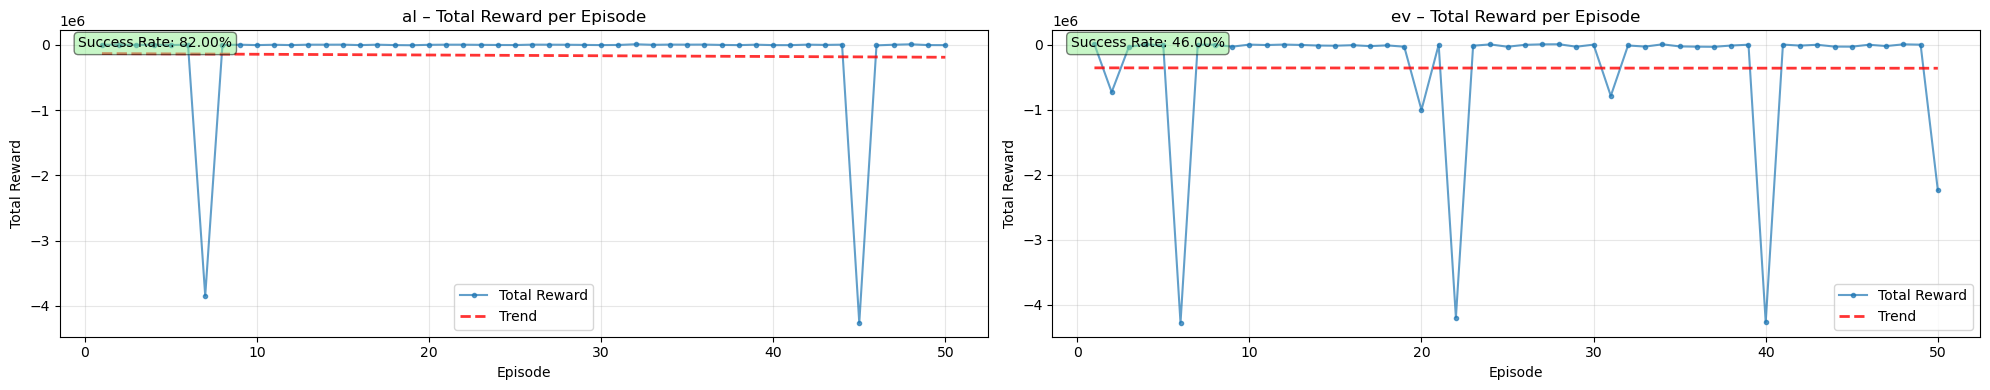

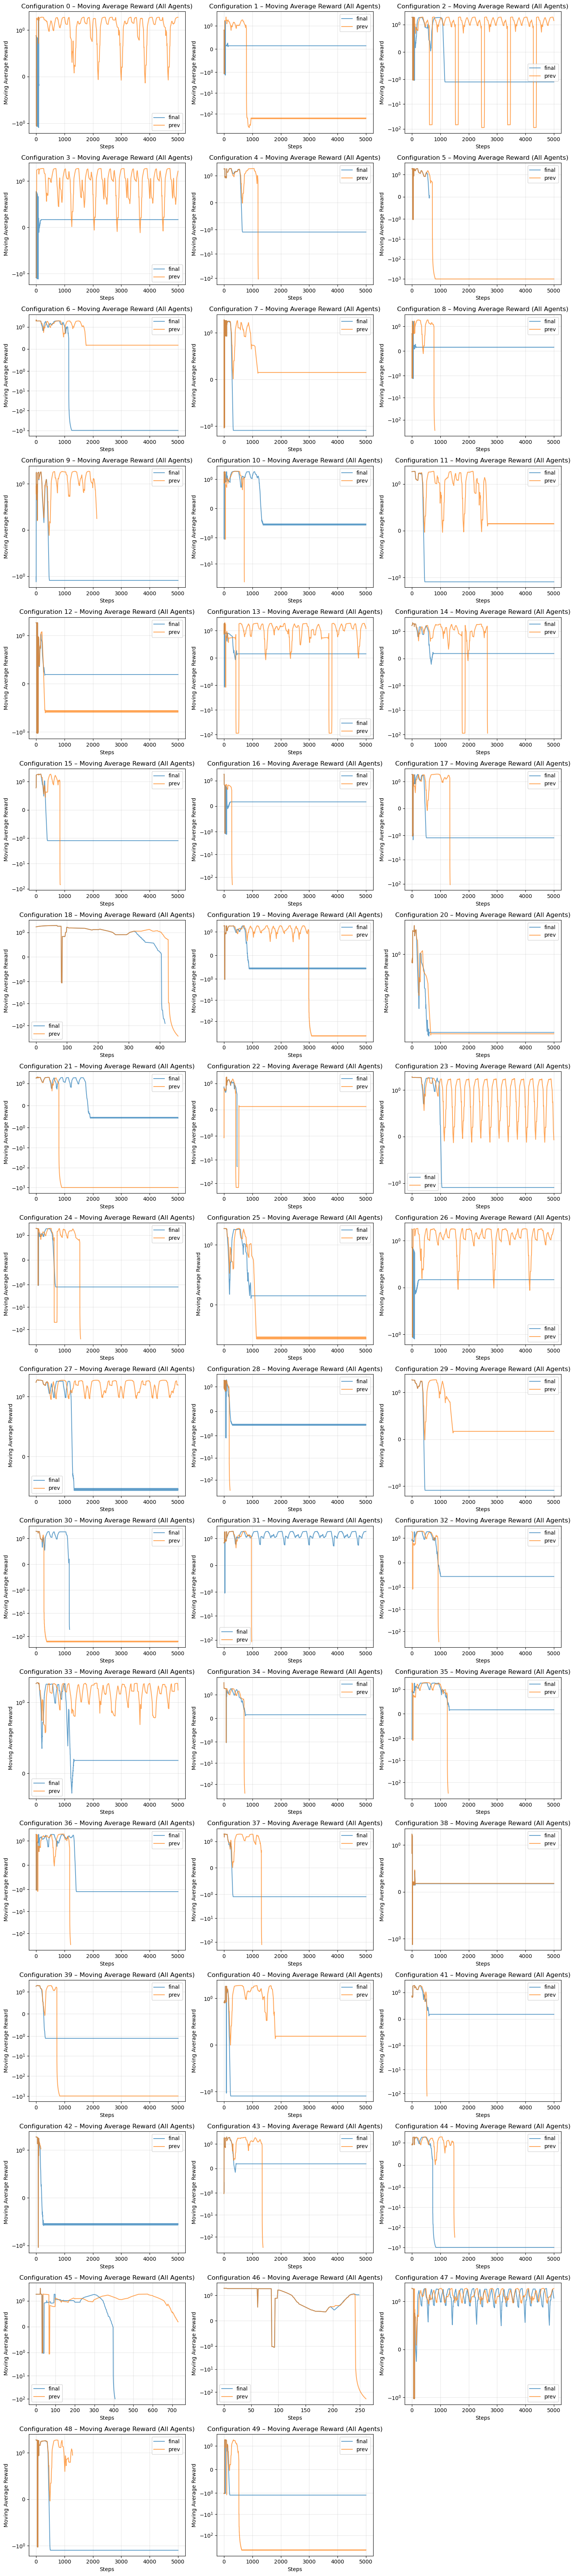

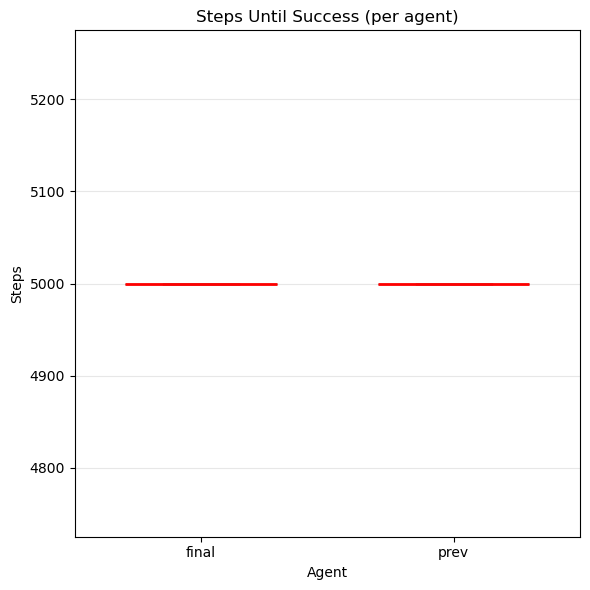

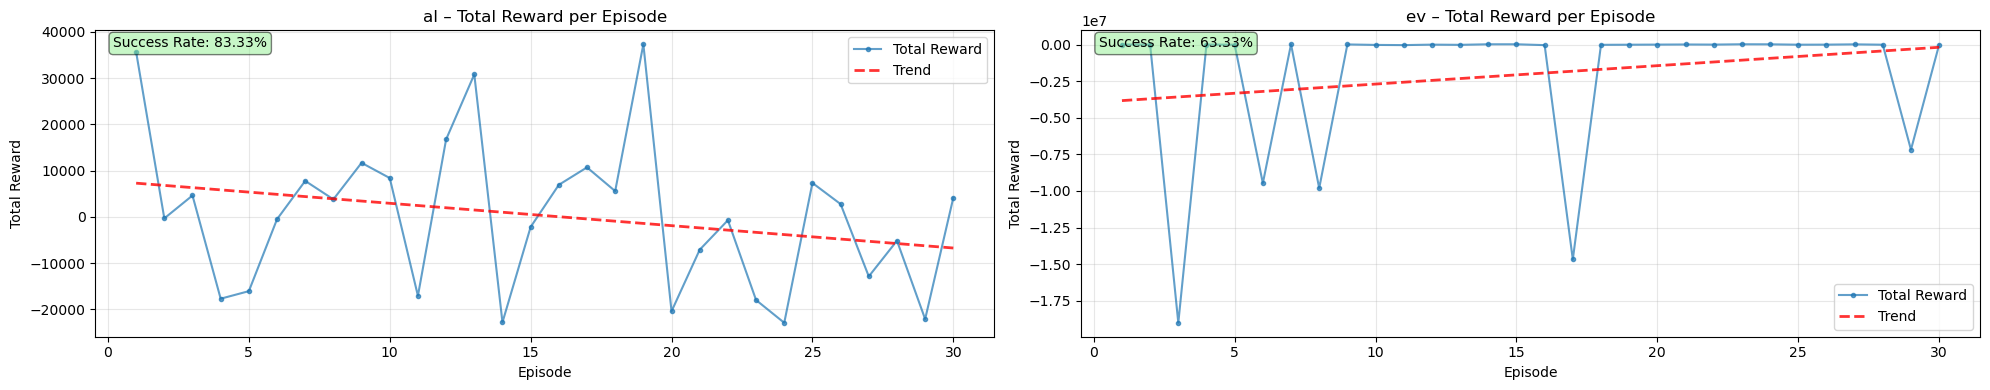

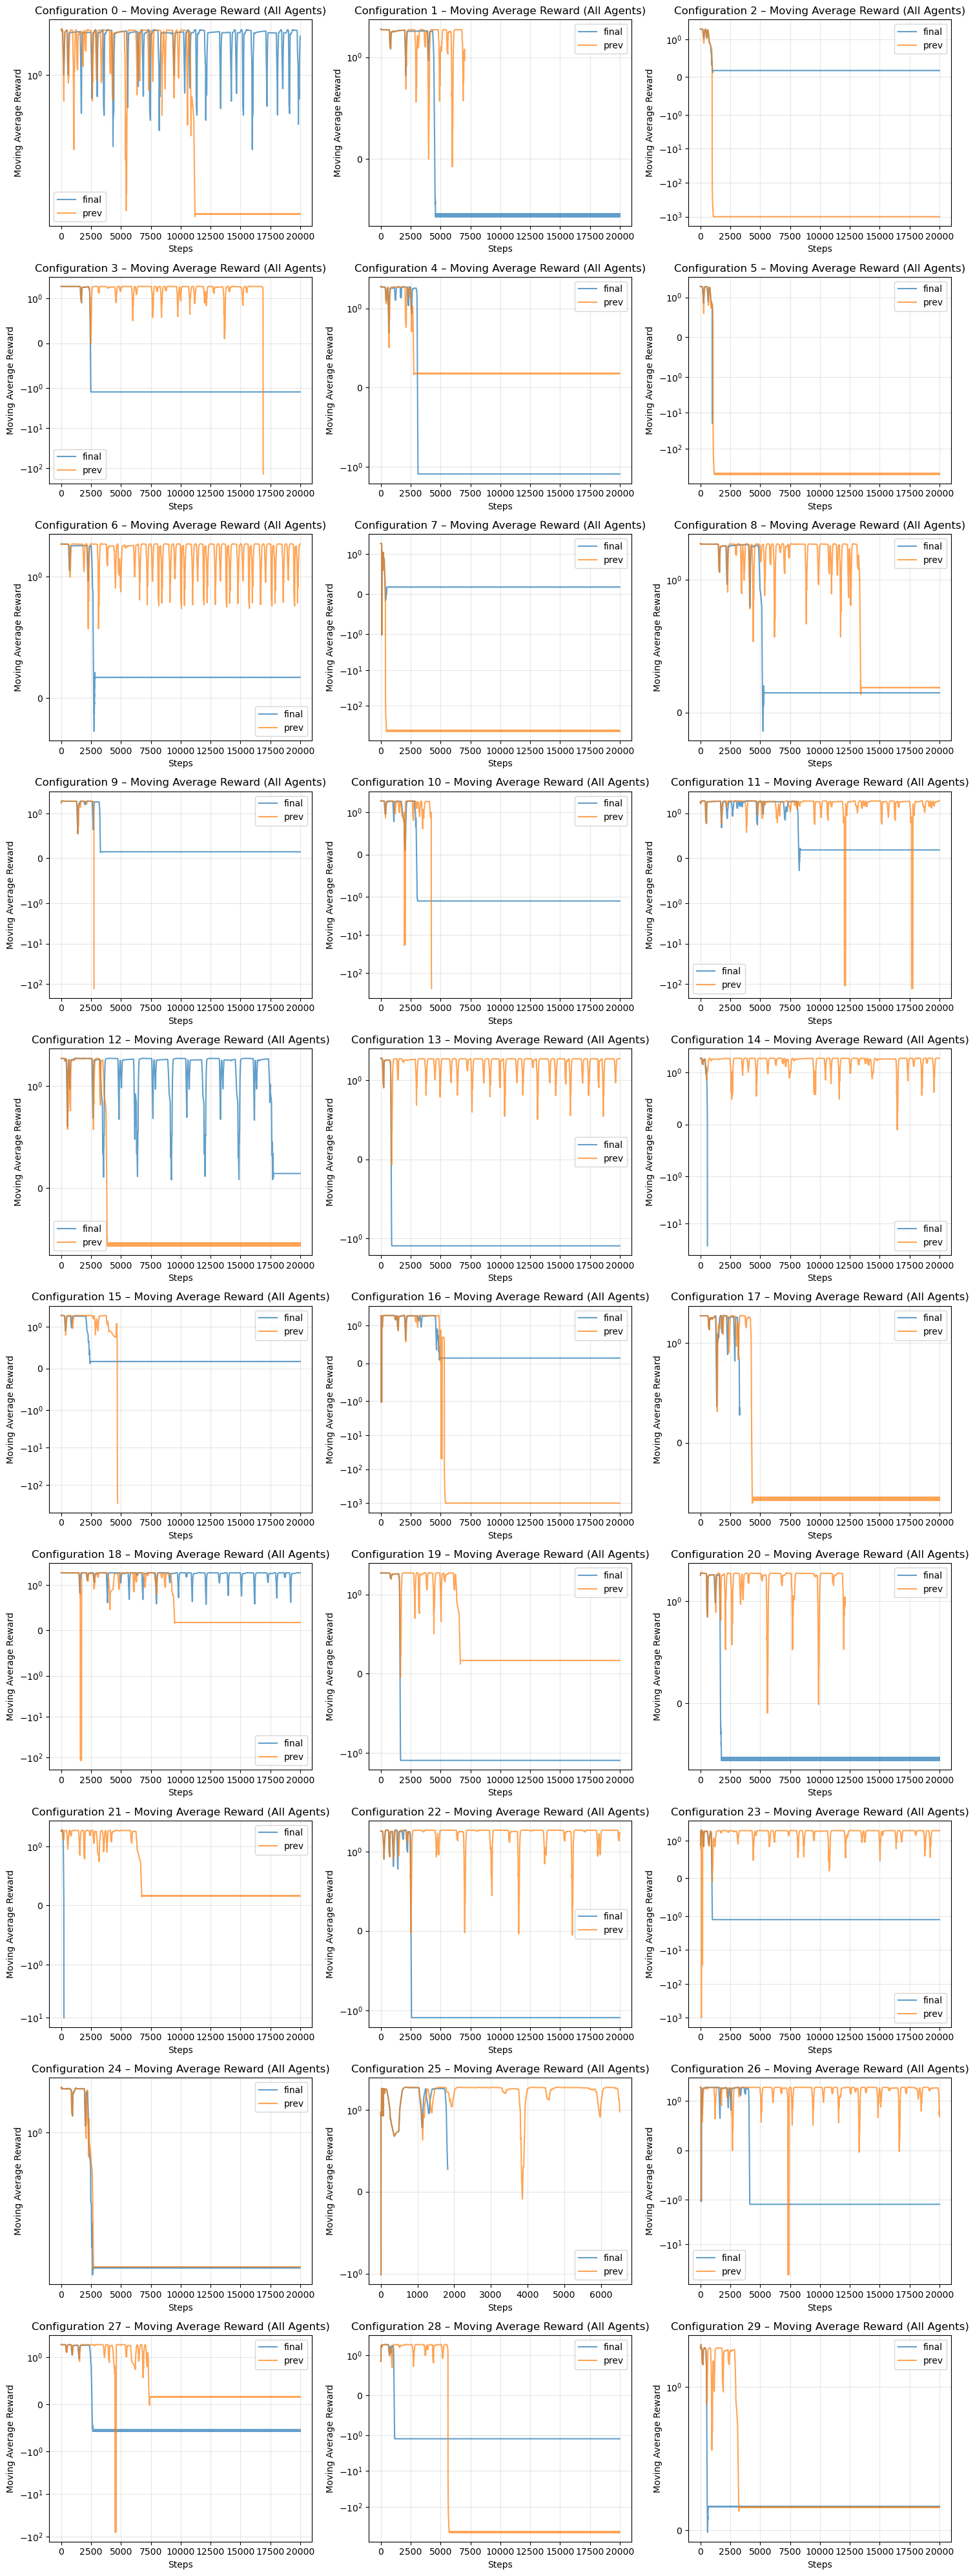

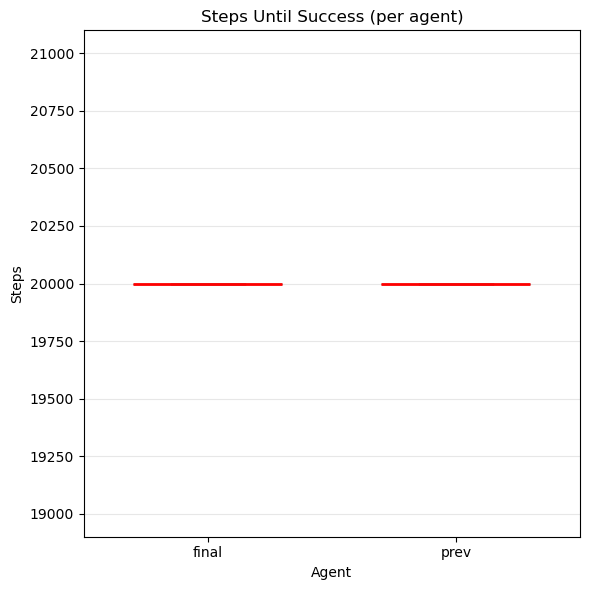

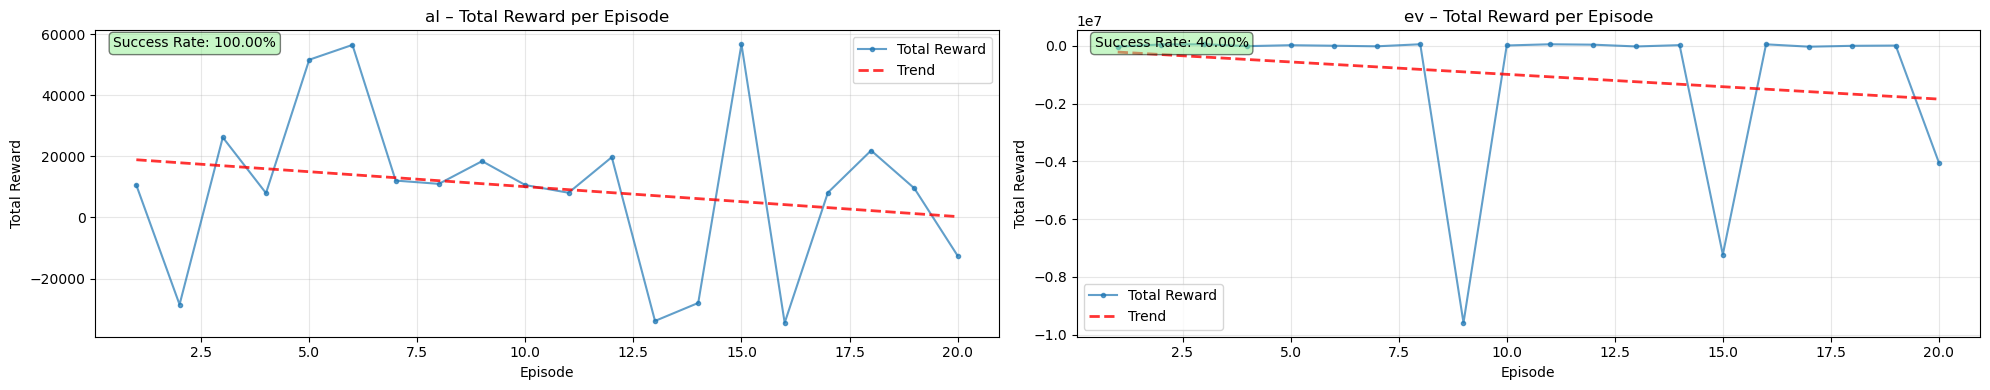

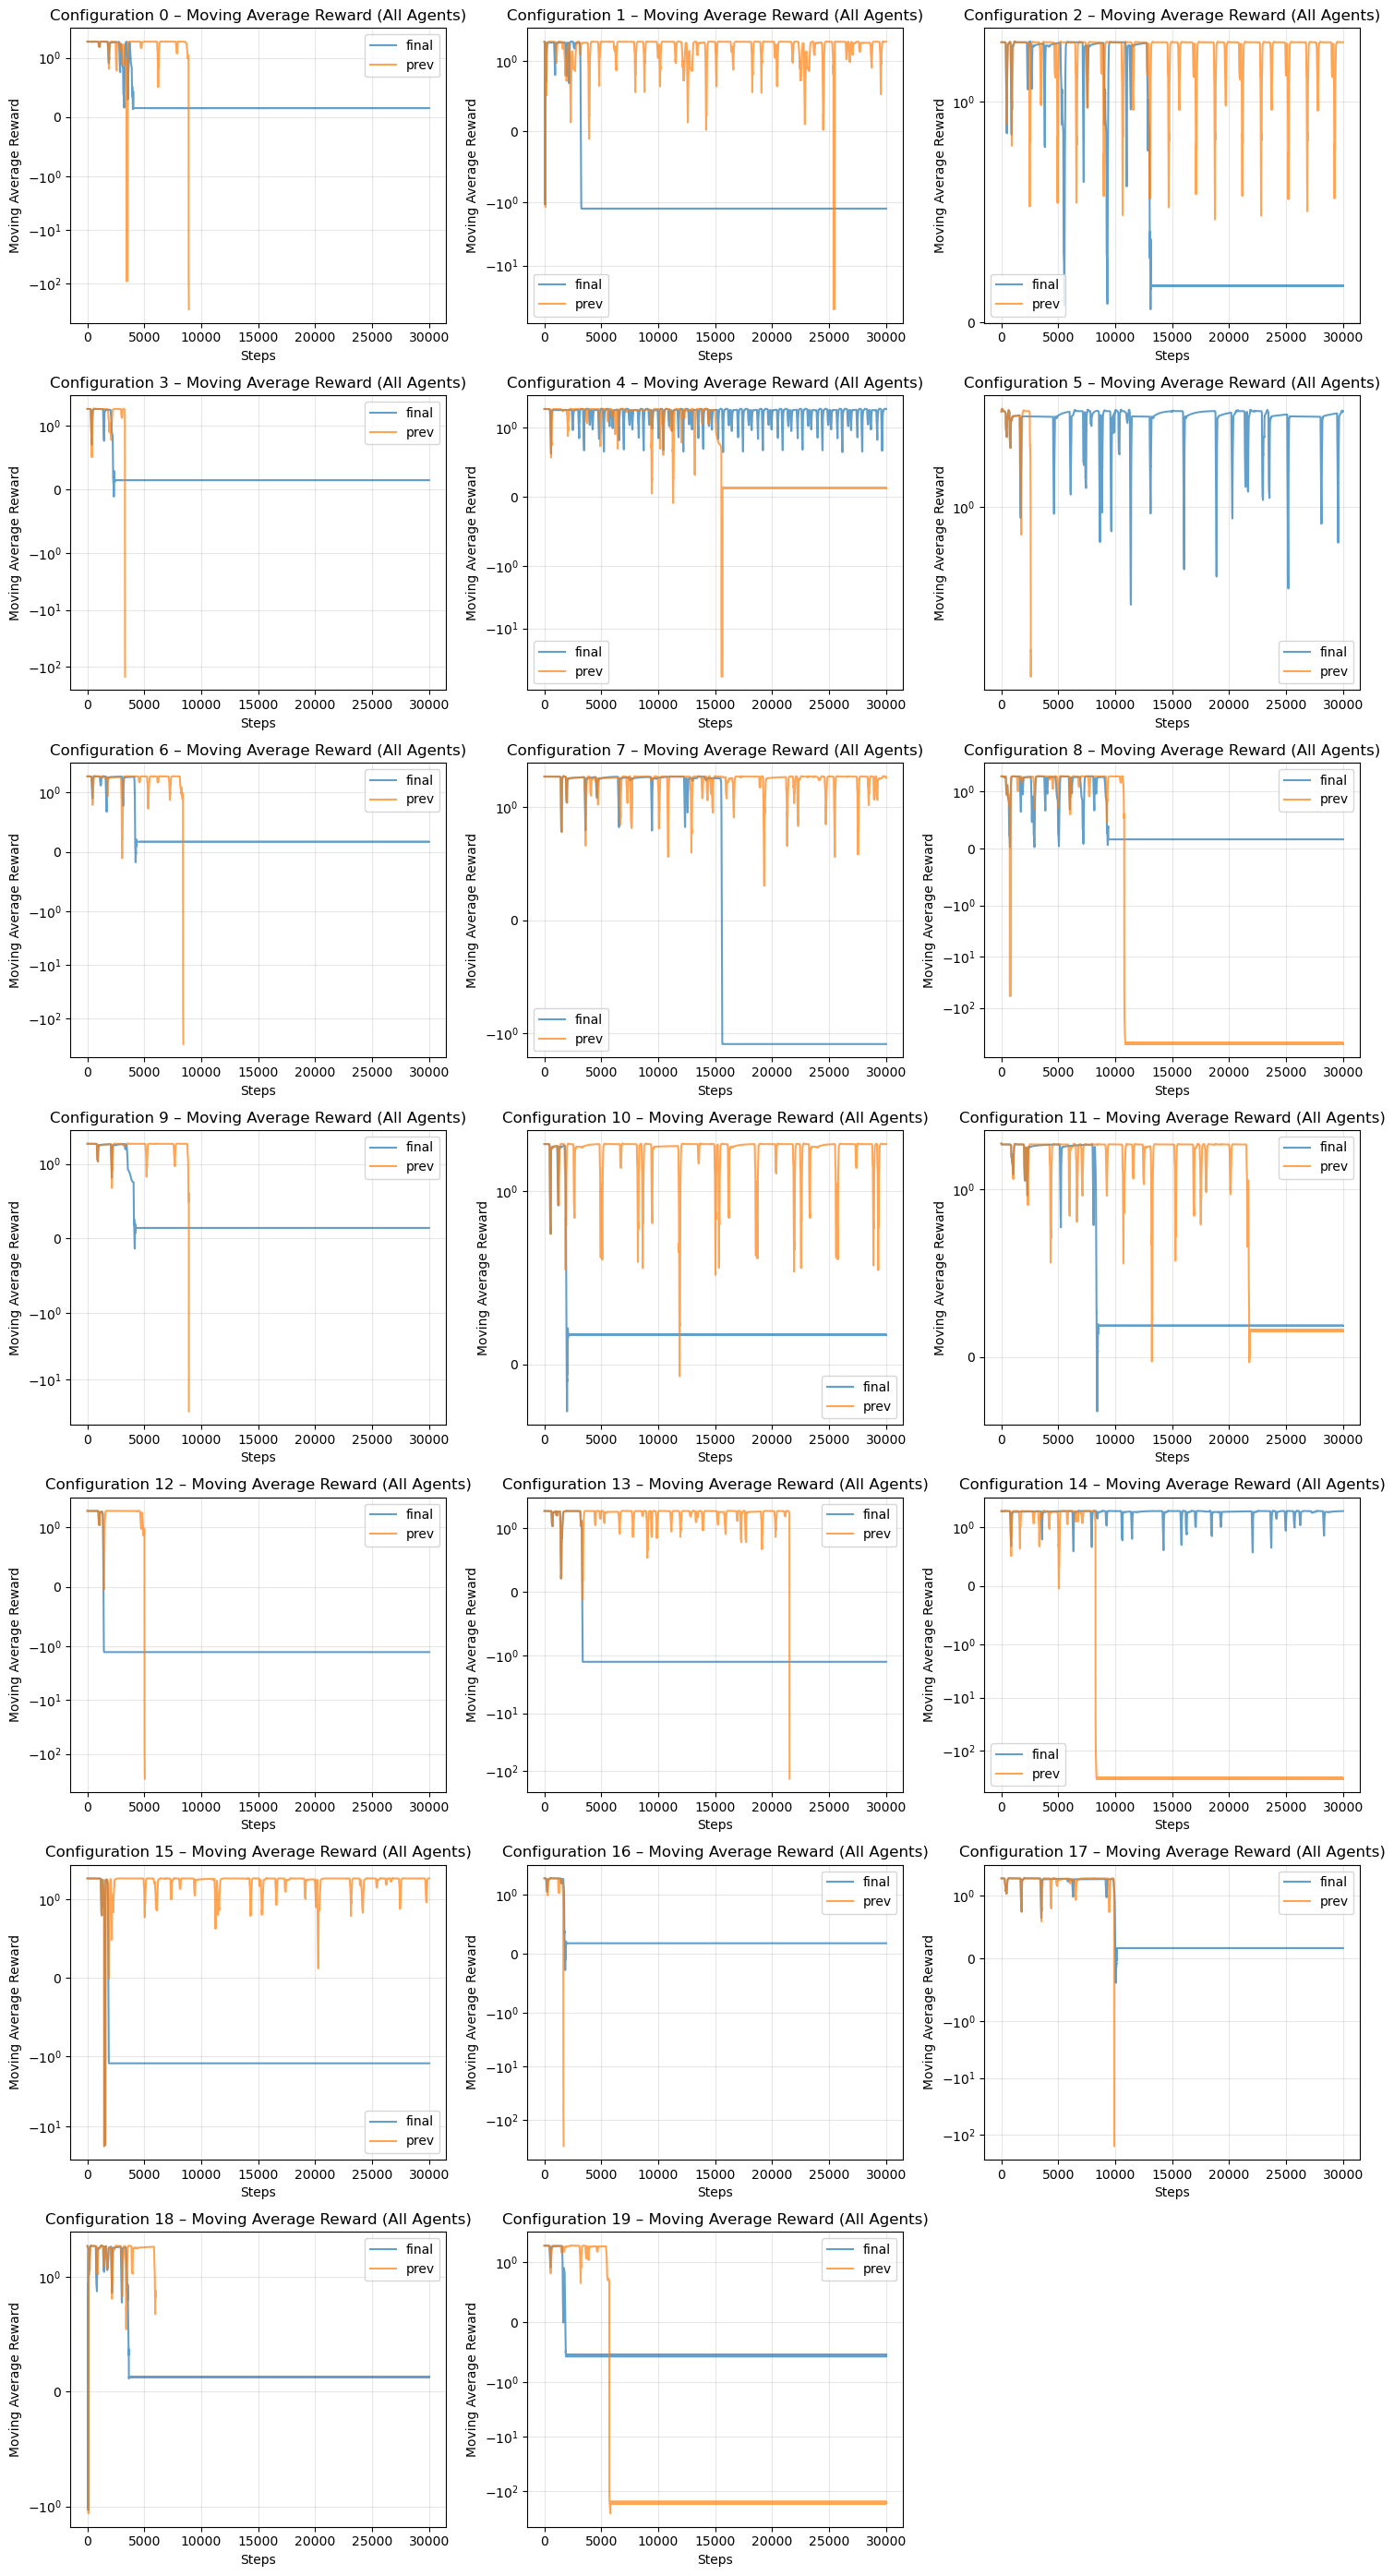

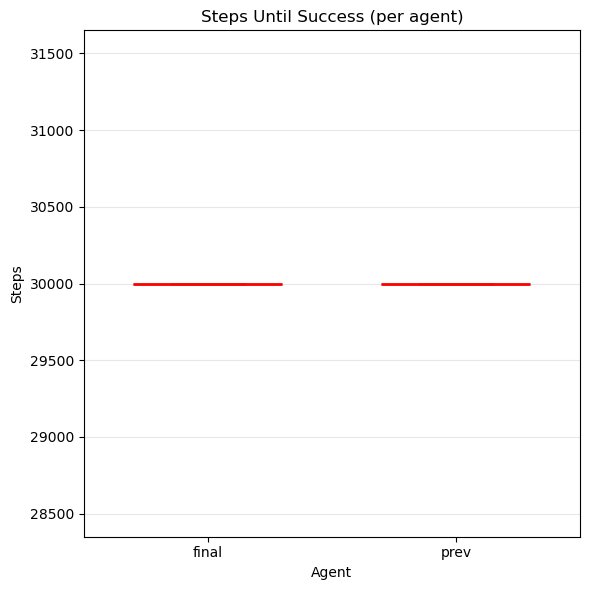

In [ ]:
plot_all_q_agent(q_results_5, agents=["final", "prev"])
plot_all_q_agent(q_results_20, agents=["final", "prev"])
plot_all_q_agent(q_results_30, agents=["final", "prev"])


### Analisi errori

#### Success rate per dimensione ambiente

Dai risultati sopra mostrati, si può osservare come, in entrambi i checkpoint caricati, l'agente ottiene un successo che non dipende significativamente dalla dimensione dell'ambiente.
Questo indica che l'agente è stato in grado di generalizzare il comportamento appreso durante l'addestramento, effettuato in ambienti 10x10 metri.
Un dato interessante è che l'agente indicato come "final" ottiene un successo decisamente migliore rispetto all'agente salvato nel checkpoint precedente, a prima vista sembra che l'apprendimento sia progredito in modo significativo tra i due checkpoint.
Tuttavia, un'analisi più approfondita della *moving average reward* durante la valutazione mostra che l'agente "final" si trova più spesso in situazioni nelle quali esegue ripetutamente le stesse azioni senza fare progressi, indicando la presenza di loop comportamentali.

#### Moving average reward durante la valutazione

Ovviamente, per il task in esame, non è possibile analizzare la *median steps to success* in quanto gli episodi di valutazione non terminano mai con successo prima del raggiungimento del numero massimo di passi.

È però possibile ottenere informazioni significative analizzando la *moving average reward* durante la valutazione. Si nota infatti che l'agente salvato nel checkpoint precedente si mostra meno soggetto a loop comportamentali rispetto all'agente "final".
Per questo motivo, nonostante l'agente "final" abbia un successo complessivamente migliore, l'agente del checkpoint precedente potrebbe essere considerato più robusto in termini di comportamento.

##### Analisi visiva del comportamento

![Final Agent Behavior](resources/oa-qagent-final-stuck.gif)

Come si può osservare sopra, l'agente "final" tende a bloccarsi anche in situazioni relativamente semplici.
Questo comportamento è probabilmente dovuto al fatto che l'agente ha appreso a massimizzare la reward in situazioni specifiche, ma non è riuscito a sviluppare strategie generali per evitare gli ostacoli in modo efficace.
Al contrario, l'agente salvato nel checkpoint precedente mostra un comportamento più stabile nelle stesse situazioni, entrando in loop comportamentali solamente in scenari più complessi.
Sotto è mostrato come l'agente del checkpoint precedente si comporta all'interno dello stesso ambiente.

![Previous Checkpoint Agent Behavior](resources/oa-qagent-prev-moving.gif)

##### Loop comportamentali

I loop comportamentali si manifestano in situazioni in cui l'agente si trova intrappolato in una serie di azioni ripetitive che non portano a progressi significativi nell'evitare gli ostacoli.
Questi loop avvengono per sequenze di azioni, e relative osservazioni, che si ripetono ciclicamente, del tipo:

- `[act_1, obs_1] -> [act_2, obs_2] -> [act_3, obs_3] -> [act_1, obs_1] -> [act_2, obs_2] -> ...`

Nella maggior parte dei casi, questi loop si verificano in situazioni in cui l'agente si trova vicino a ostacoli o in spazi ristretti, dove le opzioni di movimento sono limitate.
Dato che l'agente utilizza un approccio basato su Q-Learning è impossibile per lui uscire da questi loop una volta che si sono instaurati.

Quando l'agente entra in un loop comportamentale, la *moving average reward* tende a stabilizzarsi a valori negativi, la penalità totale ricevuta durante il loop supera la penalità per la collisione.
Questo dettaglio è importante in quanto indica che l'agente non sta semplicemente evitando la collisione, ma si trova effettivamente in una situazione di stallo.

Date le limitazioni intrinseche del Q-Learning, risulta difficile eliminare completamente questi loop comportamentali.

#### Commenti finali

In conclusione, l'agente basato su Q-Learning ha mostrato buone capacità di apprendimento e generalizzazione del comportamento di evitamento degli ostacoli, nonostante la presenza di loop comportamentali in alcune situazioni.
Tecniche più avanzate, come l'uso di reti neurali per approssimare la funzione Q, sono mostrate successivamente e hanno permesso di superare alcune delle limitazioni riscontrate con l'approccio basato su tabelle Q.

# DQ-Learning

Il task di obstacle avoidance è stato successivamente affrontato utilizzando un agente basato su Deep Q-Learning (DQN).

Questo approccio ha permesso di superare alcune delle limitazioni riscontrate con l'agente basato su Q-Learning, in particolare per quanto riguarda la gestione di spazi di osservazione più complessi e la capacità di generalizzazione.

Si è sfruttata come base la soluzione implementata per il Q-Agent, mantenendo inizialmente la stessa funzione di reward, le stesse azioni e configurazioni ambientali.

## Import delle librerie

In [18]:
from environment.deepqlearning.obstacle_avoidance_env import ObstacleAvoidanceEnv as DQOAEnv
from agent.scala_dqagent import DQAgent
from training.dqnetwork import DQNetwork

## Connessione all'ambiente

In [19]:
server_address = "localhost:50051"
client_name = "RLClient"
dq_env = DQOAEnv(server_address, client_name)
dq_env.connect_to_client()

2025-12-01 14:36:25,487 — INFO — ✓ Connected to localhost:50051



## Problemi riscontrati

Durante lo svolgimento del task, il principale problema riscontrato è stato legato alla definizione della funzione di reward.

Il DQ-Agent aveva una percentuale di successo molto più bassa rispetto al Q-Agent, circa il 10% contro il 50% del Q-Agent.
Questo comportamento, osservando visivamente il comportamento dell'agente, era dovuto al fatto che esso tendeva a restare molto vicino agli ostacoli, di conseguenza spesso collidendo con gli spigoli degli stessi.

Una seconda problematica inizialmente riscontrata era legata alla capacità dell'agente di generalizzare il comportamento appreso in situazioni diverse da quelle viste durante l'addestramento. Questo problema era dovuto alla configurazione della rete neurale utilizzata per approssimare la funzione Q, la quale disponeva di un singolo layer nascosto con 8 neuroni. Questa architettura si è rivelata insufficiente per catturare la complessità del task.

## Configurazioni ambienti

Per gli addestramenti sono stati utilizzati gli stessi ambienti descritti per il Q-Agent, in modo da poter confrontare direttamente le performance dei due agenti.

Sono state effettuate alcune prove sia con un numero elevato di configurazioni ambientali (10000) sia con un numero ridotto (300), riscontrando caratteristiche diverse rispetto a quanto osservato con il Q-Agent, che saranno descritte in seguito.

Come verrà descritto nella sezione riguardante la reward utilizzata, l'agente ha mostrato difficoltà inizialmente nel mantenere una distanza adeguata dagli ostacoli, portando a numerose collisioni.
Le differenti configurazioni ambientali hanno avuto un impatto significativo su questo comportamento, in particolare:

- con un numero elevato di configurazioni ambientali, generate casualmente, l'agente presentava difficoltà maggiori nel mantenere una buona distanza dagli ostacoli, preferendo mantenersi vicino ad essi. Un comportamento particolare osservato era che l'agente tendeva ad avvicinarsi agli ostacoli tramite oscillazioni ripetute, nel tentativo di ottenere letture di prossimità dai sensori disposti lateralmente; questa strategia portava all'ottenimento di ricompense più basse di quelle ottenibili mantenendo una distanza maggiore dagli ostacoli, ma l'agente sembrava non riuscire a identificare questa differenza. Questa strategia portava inoltre l'agente a collidere spesso con gli spigoli degli ostacoli.
- con un numero ridotto di configurazioni ambientali, selezionate manualmente, l'agente riusciva a mantenere una distanza maggiore dagli ostacoli, riducendo il numero di collisioni. Questo comportamento era dovuto al fatto che le configurazioni ambientali selezionate permettevano all'agente di muoversi agevolmente all'inizio, per poi incontrare ostacoli più complessi, favorendo l'apprendimento di strategie più efficaci per l'evitamento degli ostacoli. Nonostante il numero ridotto di configurazioni, l'agente è stato in grado di generalizzare il comportamento appreso anche in ambienti più grandi e più piccoli durante la fase di valutazione.

## Approccio risolutivo

Di seguito vengono mostrate le soluzioni adottate per risolvere i problemi riscontrati e la realizzazione dell'agente di Deep Q-Learning.

### Reward

Come descritto nei problemi riscontrati, la funzione di reward utilizzata per addestrare il Q-Agent non si è rivelata adatta per il DQ-Agent.
È però risultato sufficiente apportare una semplice modifica alla componente `clearance_reward`, aumentando la penalità relativa alla prossimità agli ostacoli.

Questa modifica ha portato a un miglioramento significativo del comportamento dell'agente, che ha iniziato a mantenere una distanza maggiore dagli ostacoli, riducendo di conseguenza il numero di collisioni.

### Termination

Per la terminazione dell'episodio si è mantenuta la stessa regola utilizzata per il Q-Agent, ovvero la terminazione avviene solamente in caso di collisione con un ostacolo.

### Truncation

Anche per la troncatura dell'episodio si è mantenuta la stessa regola utilizzata per il Q-Agent, ovvero l'episodio viene troncato quando l'agente raggiunge il numero massimo di passi consentiti per l'ambiente in cui si trova.

### Deep-Q-Agent

L'agente con il quale sono stati ottenuti i migliori risultati dispone di una rete neurale con le seguenti caratteristiche:

| Layer | Tipo | Neuroni | Funzione di Attivazione |
|-------|------|---------|-------------------------|
| Input | Dense | 8 | - |
| Hidden 1 | Dense | 64 | ReLU |
| Hidden 2 | Dense | 32 | ReLU |
| Output | Dense | 5 | - |

Come *loss function* è stata utilizzata la *Mean Squared Error* (**MSE**), mentre come ottimizzatore si è scelto **Adam** con un learning rate di 0.001.

Gli iperparametri utilizzati per l'addestramento dell'agente sono i seguenti:

| Parametro | Valore | Descrizione |
|-----------|--------|-------------|
| ε-max | 1.0 | Valore iniziale di epsilon |
| ε-min | 0.01 | Valore minimo di epsilon |
| γ (gamma) | 0.99 | Fattore di sconto |
| Decay di ε | Esponenziale | Modalità di decadimento |

Per l'addestramento sono stati utilizzati:

| Parametro | Valore | Descrizione |
|-----------|--------|-------------|
| Replay Buffer Size | 100000 | Dimensione del buffer di esperienza |
| Batch Size | 64 | Dimensione del batch per l'aggiornamento |
| Update Frequency | 4 step | Frequenza aggiornamento rete principale |
| Target Update Frequency | 1000 step | Frequenza copia pesi nella rete target |


In [ ]:
dq_init_env_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "dq-learning", "obstacle-avoidance", "5x5", "environment_0000.yml")
dq_init_env = read_file(dq_init_env_path)
dq_env.init(dq_init_env)
neuron_count_per_hidden_layer = [64, 32]
dq_agent_id = agent_id
dq_agent = DQAgent(
    dq_env, 
    agent_id=dq_agent_id, 
    action_model=DQNetwork(
        q_env.observation_space.shape,
        neuron_count_per_hidden_layer,
        q_env.action_space.n,
        summary=False,
    ),
    target_model=DQNetwork(
        q_env.observation_space.shape,
        neuron_count_per_hidden_layer,
        q_env.action_space.n,
        summary=False,
    ),
)
dq_agents = {dq_agent_id: dq_agent}

2025-12-01 14:36:25.613085: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### Caricamento agente salvato

In [21]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "dq-learning", "v1", "oa_final")
dq_agent.load(path)
print("DQ-Agent hyperparameters:")
print(f"\tEpsilon-max: {dq_agent.epsilon_max}")
print(f"\tEpsilon-min: {dq_agent.epsilon_min}")
print(f"\tGamma: {dq_agent.gamma}")
print(f"\tReplay memory max size: {dq_agent.replay_memory.maxlen}")
print(f"\tSteps per update: {dq_agent.step_per_update}")
print(f"\tSteps per update target model: {dq_agent.step_per_update_target_model}")

DQ-Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.01
	Gamma: 0.99
	Replay memory max size: 100000
	Steps per update: 4
	Steps per update target model: 1000


/nix/store/pwrhqv9fy9lbybjz9c1w283z234lzksr-python3-3.13.8-env/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Valutazione delle performance

#### Caricamento degli ambienti di valutazione

In [22]:
# 5x5 configurations
dq_config_5_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "dq-learning", "obstacle-avoidance", "5x5")
dq_yml_files_5 = sorted(dq_config_5_path.glob("*.yml"), key=lambda p: p.name)
dq_configs_5 = [read_file(yml) for yml in dq_yml_files_5]

# 20x20 configurations
dq_config_20_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "dq-learning", "obstacle-avoidance", "20x20")
dq_yml_files_20 = sorted(dq_config_20_path.glob("*.yml"), key=lambda p: p.name)  
dq_configs_20 = [read_file(yml) for yml in dq_yml_files_20]

# 30x30 configurations
dq_config_30_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "dq-learning", "obstacle-avoidance", "30x30")
dq_yml_files_30 = sorted(dq_config_30_path.glob("*.yml"), key=lambda p: p.name)  
dq_configs_30 = [read_file(yml) for yml in dq_yml_files_30]

#### Creazione della funzione di valutazione

La funzione di valutazione utilizzata è la stessa di quella utilizzata nella valutazione dell'agente q-learning, in quanto la piccola differenza nella funzione di reward utilizzata non influenza il controllo di successo/fallimento dell'episodio.

#### Valutazione dell'agente

In [23]:
dq_final_results_5 = evaluate(env=dq_env, agents=dq_agents, configs=dq_configs_5, max_steps=5000, did_succeed=did_succeed)
dq_final_results_20 = evaluate(env=dq_env, agents=dq_agents, configs=dq_configs_20, max_steps=20000, did_succeed=did_succeed)
dq_final_results_30 = evaluate(env=dq_env, agents=dq_agents, configs=dq_configs_30, max_steps=30000, did_succeed=did_succeed)

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:23:40<00:00, 251.01s/configuration run]


In [24]:
dq_final_results_5 = rename_inner_keys(dq_final_results_5, {dq_agent_id: "final"})
dq_final_results_20 = rename_inner_keys(dq_final_results_20, {dq_agent_id: "final"})
dq_final_results_30 = rename_inner_keys(dq_final_results_30, {dq_agent_id: "final"})

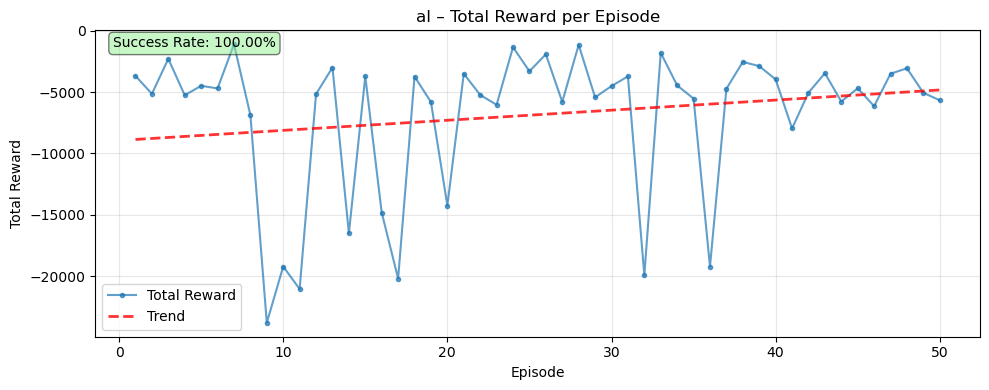

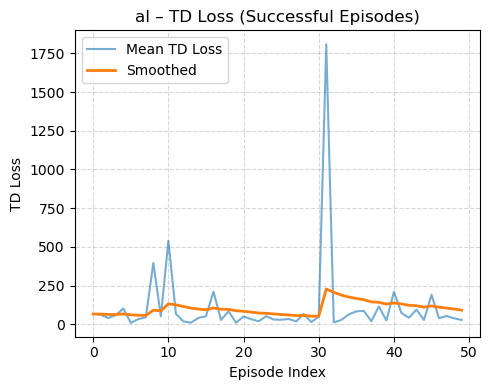

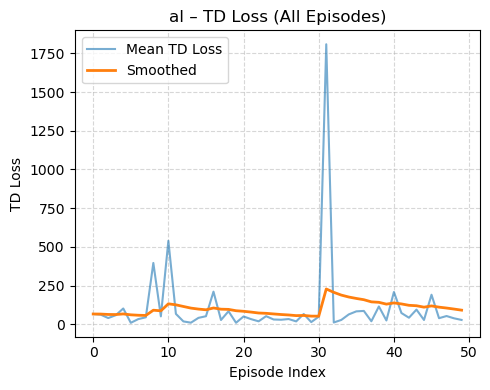

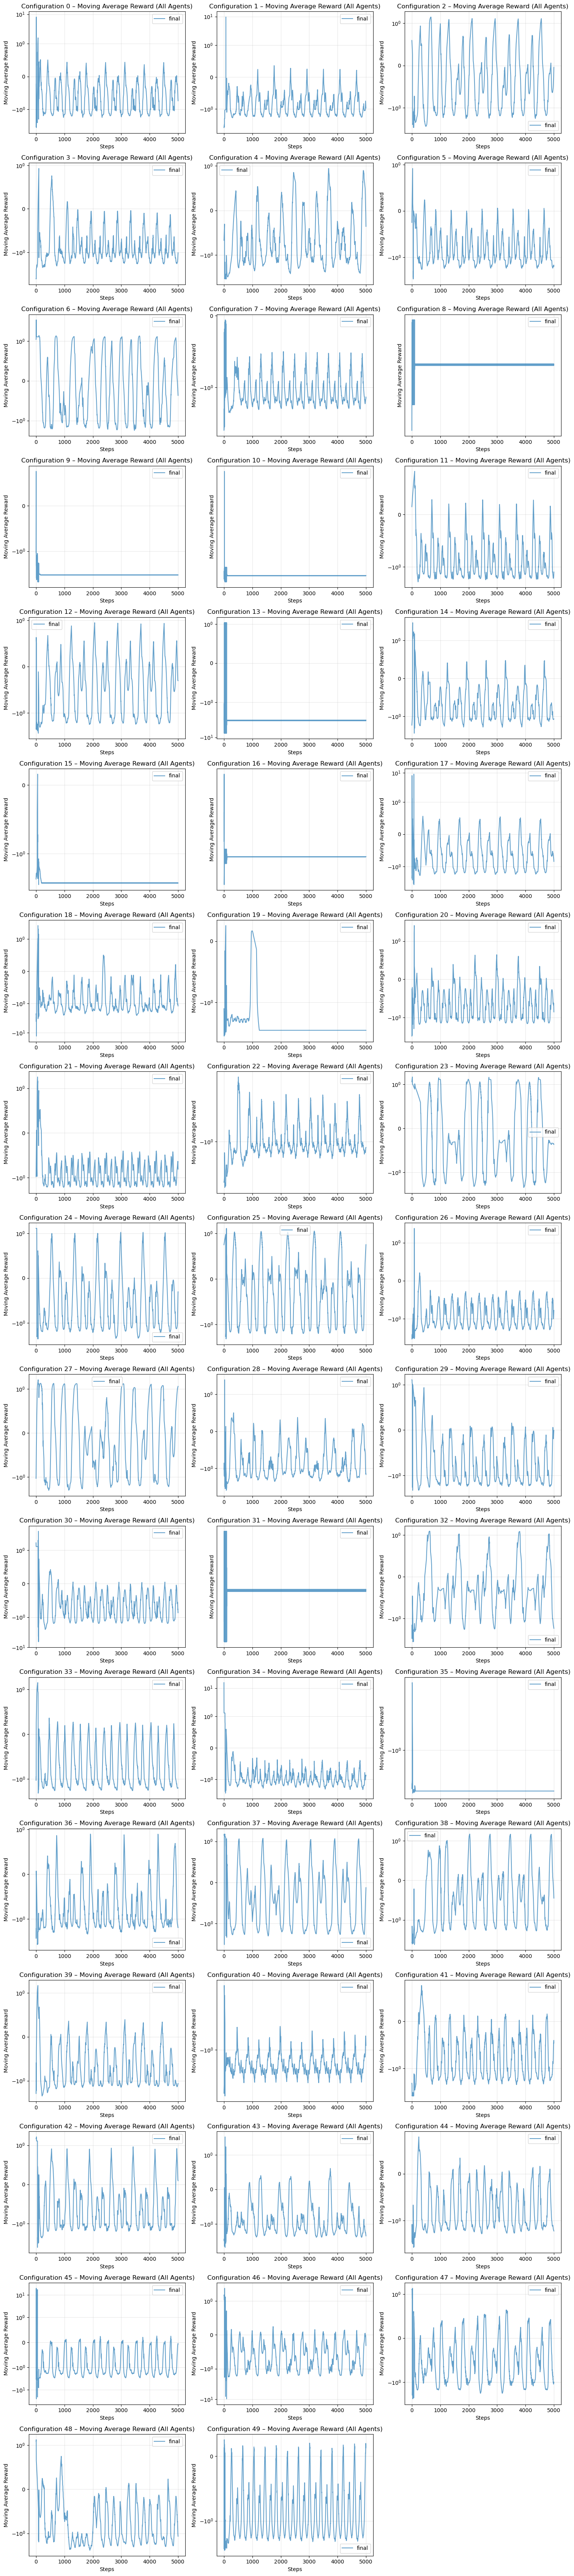

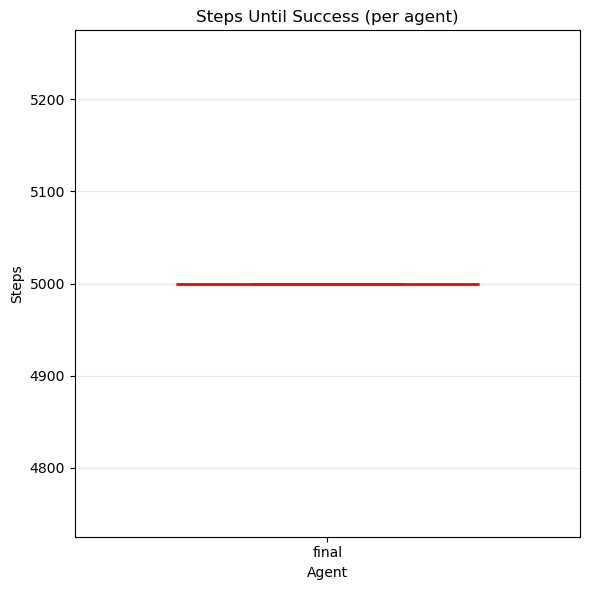

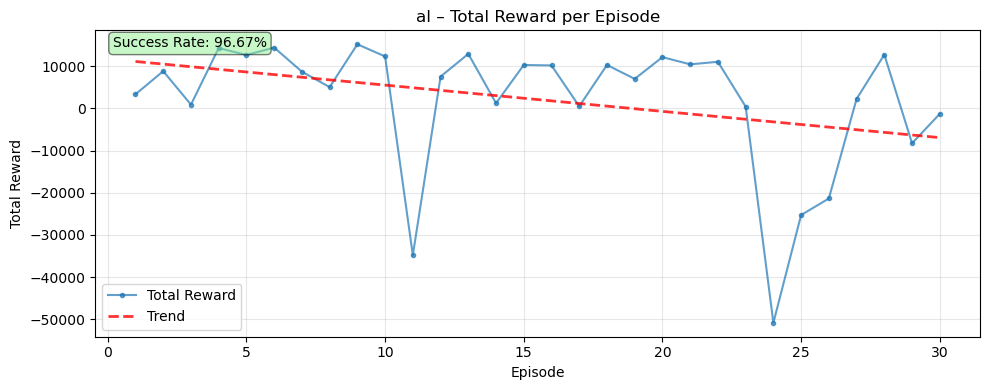

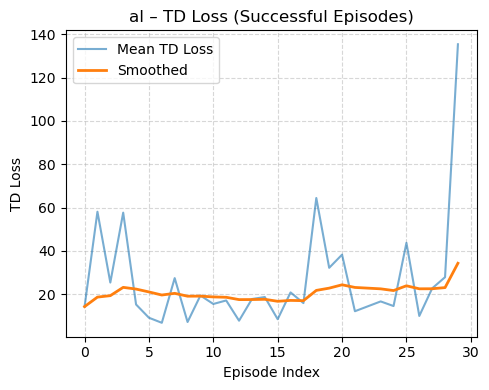

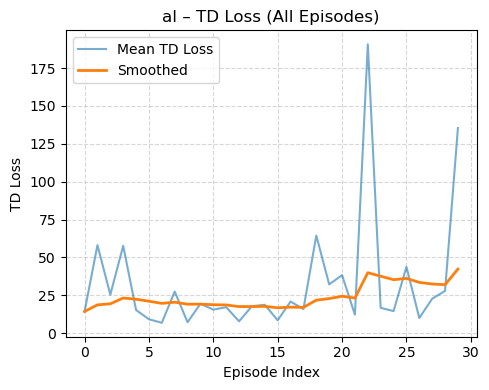

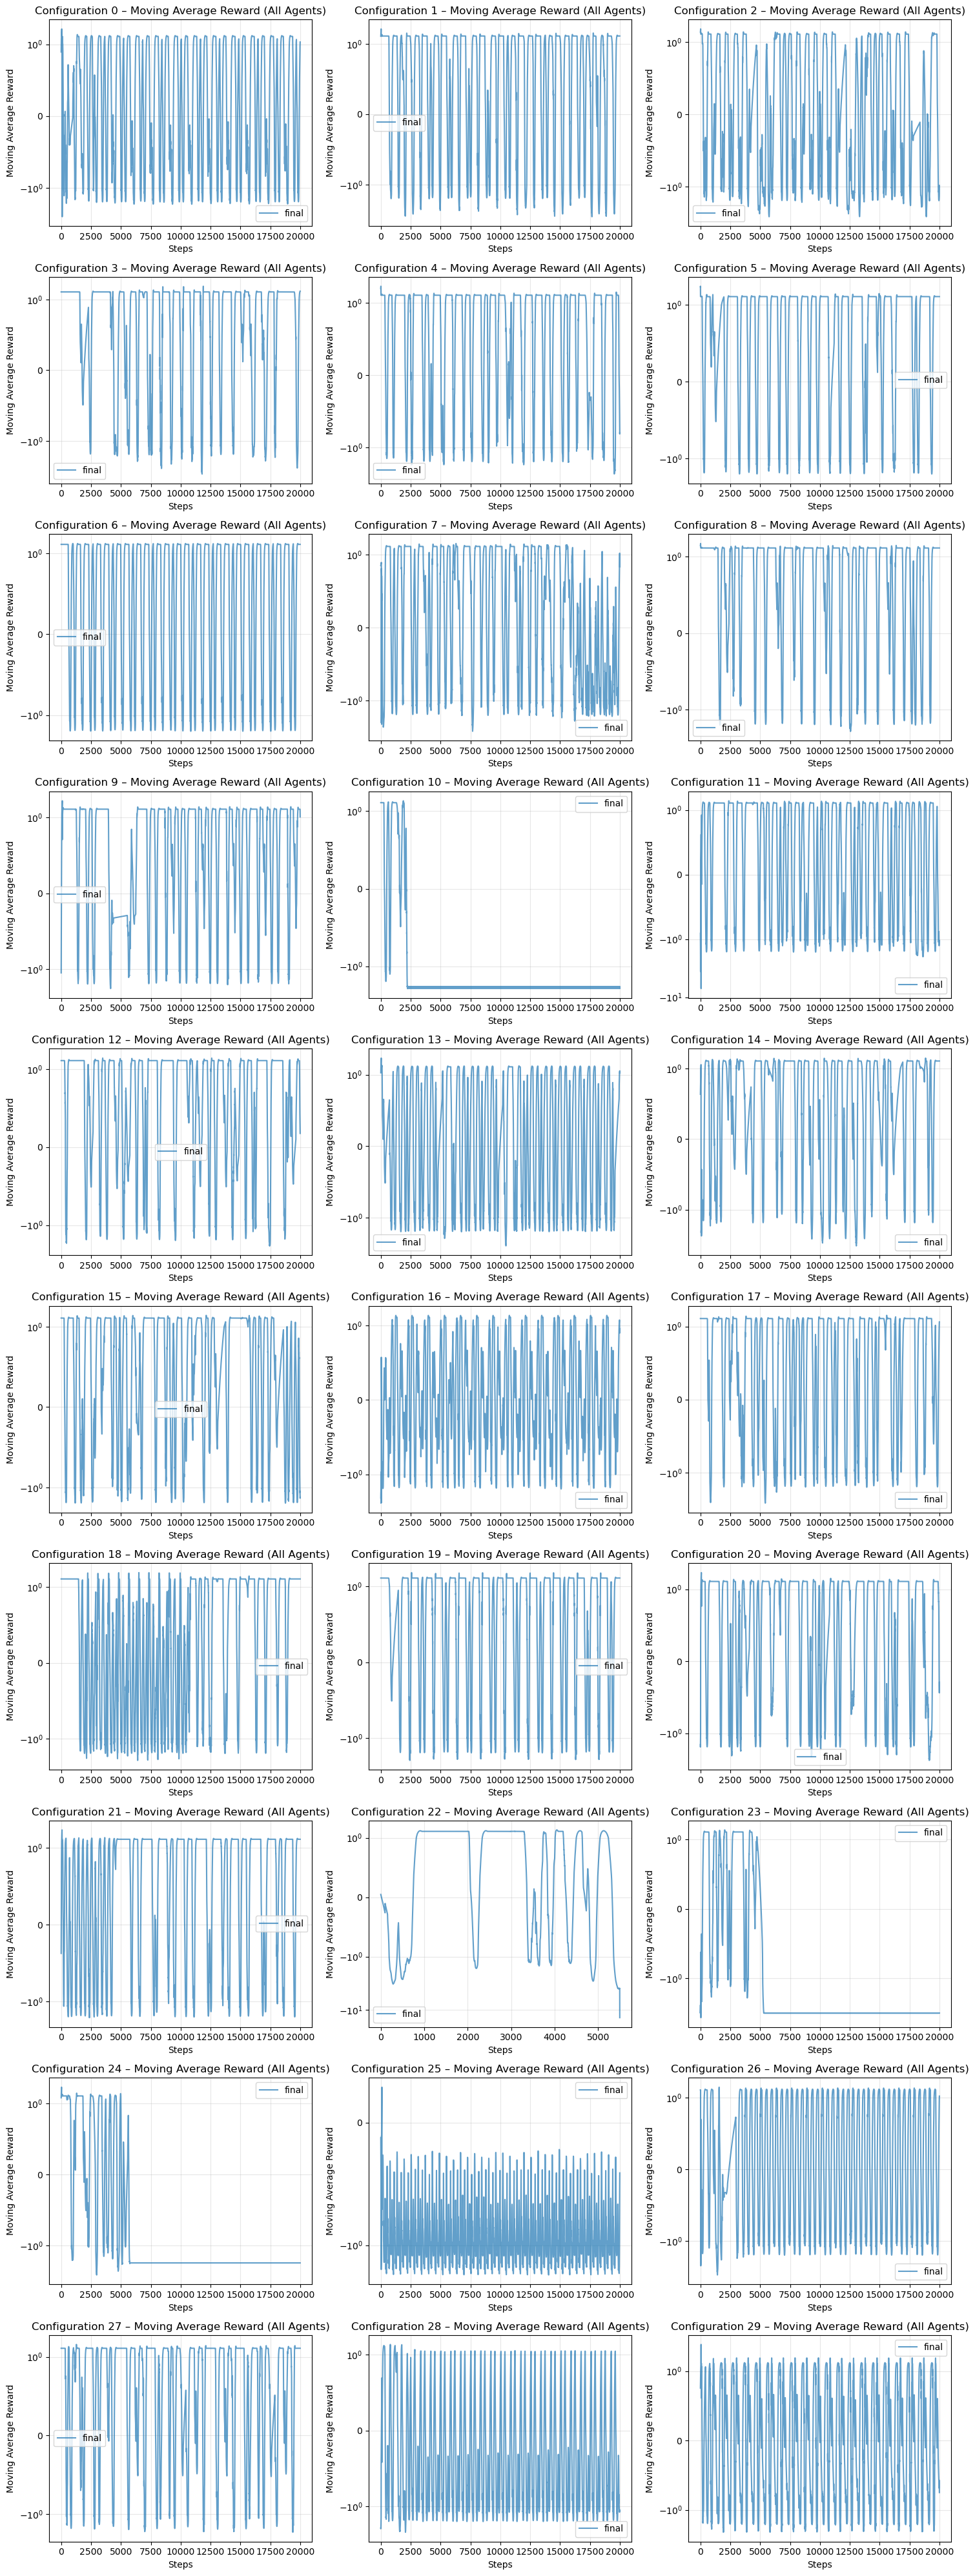

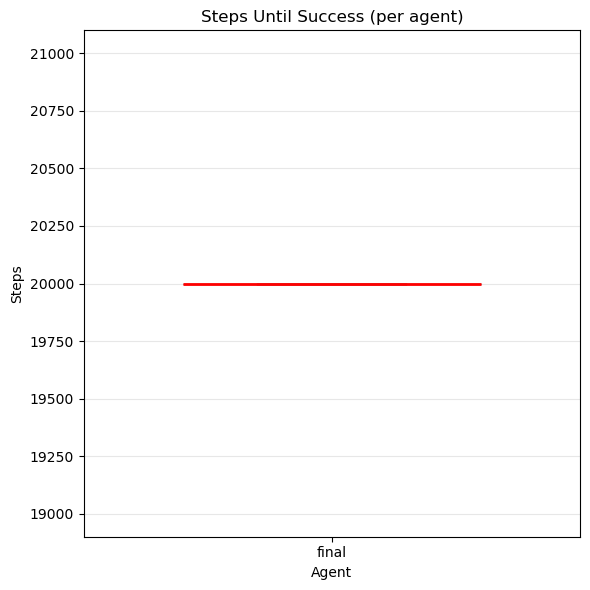

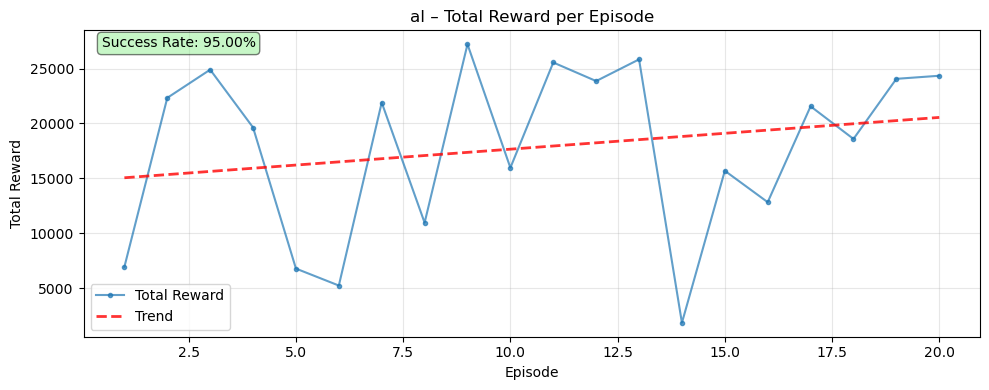

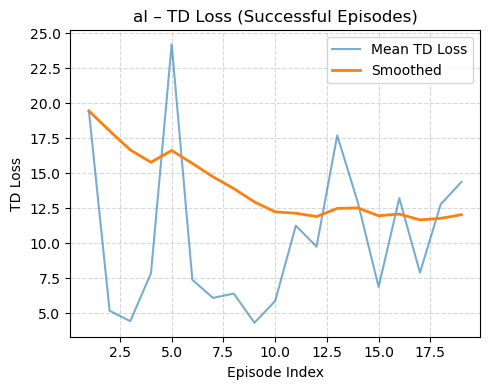

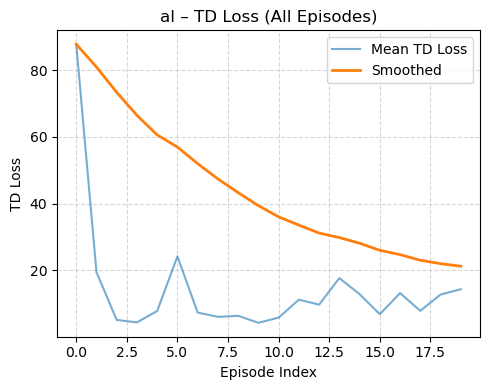

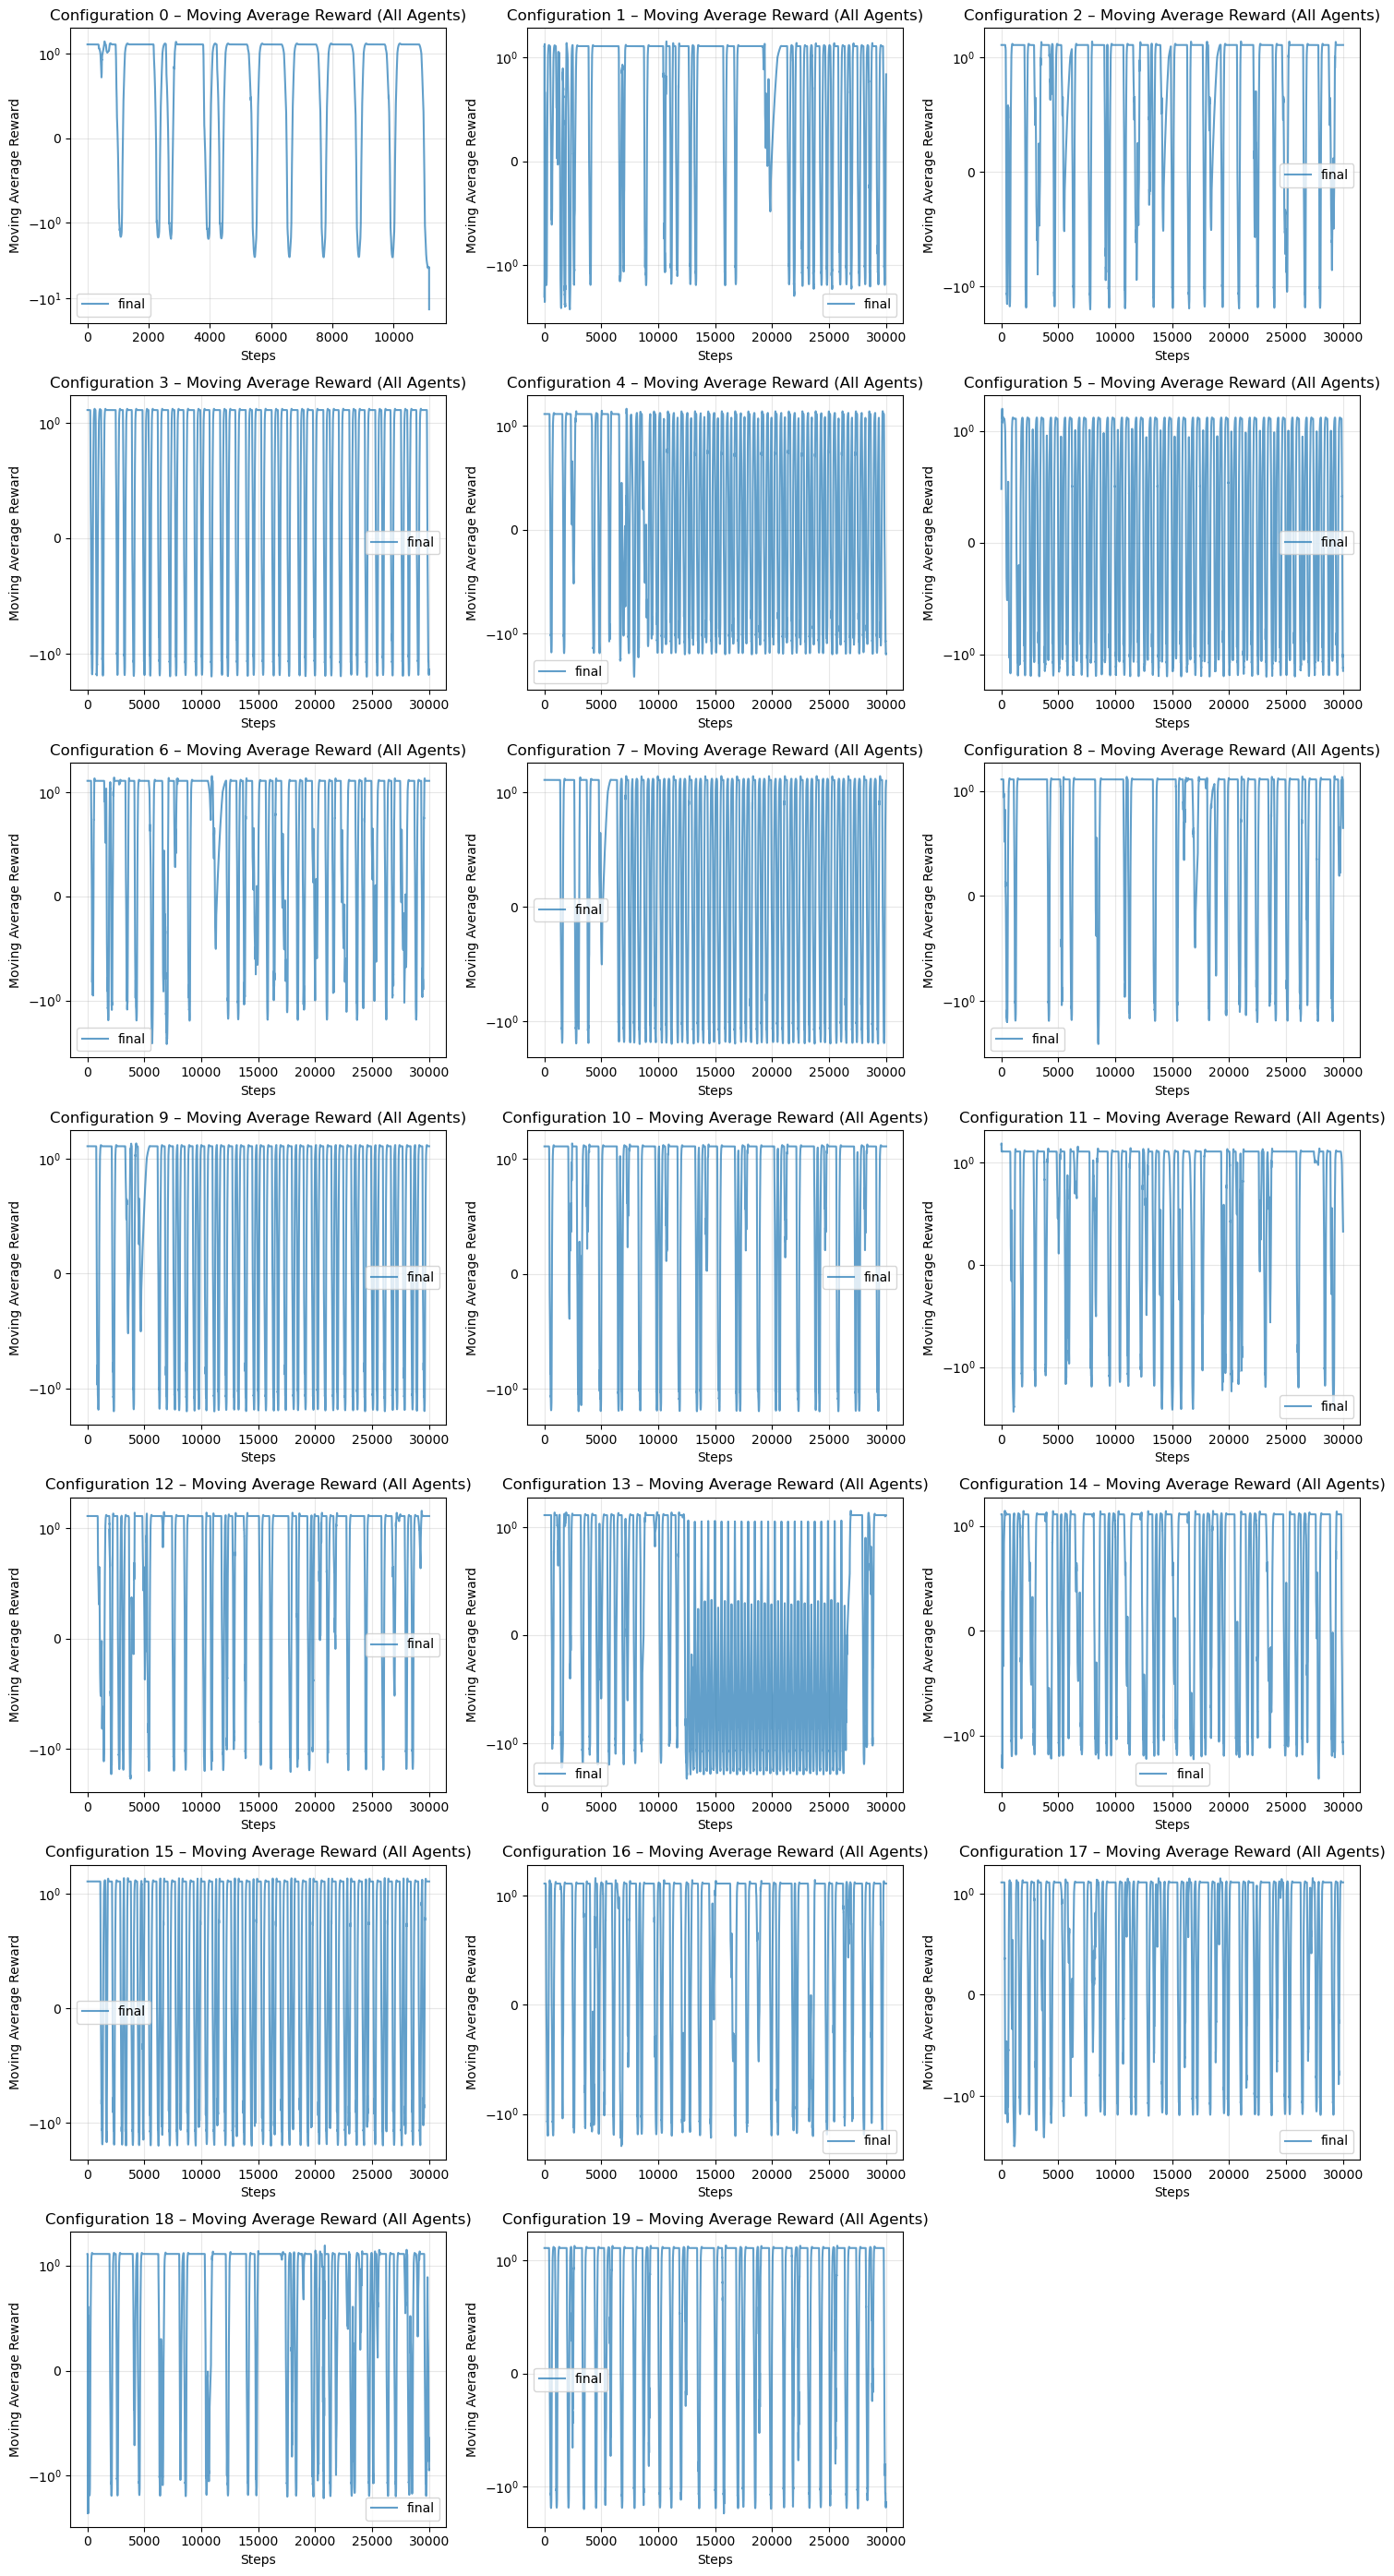

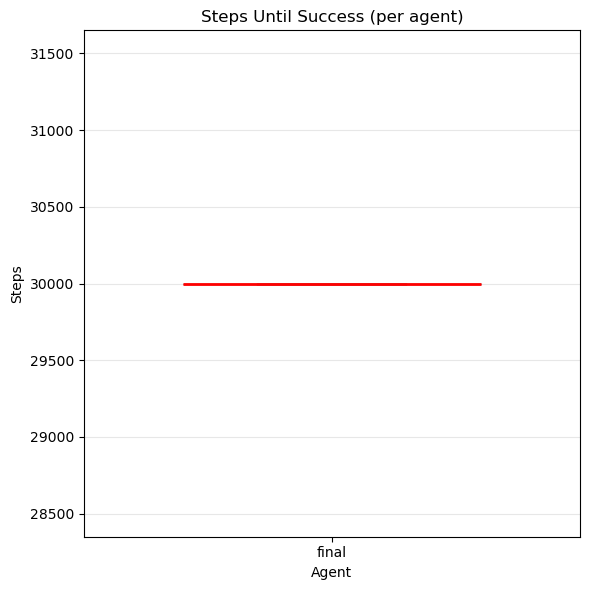

In [25]:
plot_all(dq_final_results_5, agents=["final"])
plot_all(dq_final_results_20, agents=["final"])
plot_all(dq_final_results_30, agents=["final"])

### Analisi errori

#### Success rate per dimensione ambiente

Sulla base dei risultati ottenuti, si osserva come l'agente DQ-Learning sia in grado di mantenere un successo elevato in ambienti di dimensioni diverse, dimostrando una buona capacità di generalizzazione del comportamento appreso durante l'addestramento, nonostante l'addestramento sia stato effettuato in ambienti di dimensioni intermedie (10x10 metri).

Inoltre, l'agente DQ-Learning mostra diverse caratteristiche favorevoli rispetto al Q-Agent, quali un *success rate* molto più elevato (quasi il doppio), oltre a un minor richio di incorrere in loop comportamentali, come evidenziato dalla *moving average reward* ottenuta durante la valutazione.

In questo caso il confronto tra due checkpoint differenti dell'agente DQ-Learning non viene mostrato, in quanto il checkpoint precedente è stato salvato in una fase iniziale dell'addestramento, in cui l'agente non aveva ancora appreso un comportamento efficace per l'evitamento degli ostacoli.

#### Moving average reward durante la valutazione

Dall'analisi della *moving average reward* durante la valutazione si nota come l'agente DQ-Learning entri molto meno frequentemente in loop comportamentali rispetto al Q-Agent.
Inoltre questi loop si presentano con una frequenza maggiore in ambienti di dimensioni minori, a causa della maggiore densità di ostacoli, che rende più difficile la navigazione.

Sono comunque presenti alcuni loop comportamentali, ma questi sono differenti da quelli riscontrati con il Q-Agent in quanto l'agente deep non resta fermo nella stessa posizione, ma si muove tra diversi ostacoli per poi tornare alla posizione iniziale, ripetendo questo ciclo più volte.
Si tratta quindi di un comportamento più dinamico, che per come è strutturato il task si può considerare come successo.

Per evitare anche questa tipologia di loop comportamentali, sarebbe necessario introdurre una penalità specifica nella funzione di reward, ad esempio basata sulle ultime posizioni visitate dall'agente, in modo da scoraggiare i movimenti ripetitivi. Tuttavia, questa modifica spingerebbe il task verso una direzione di esplorazione dell'ambiente, già affrontata nel task di *exploration*.

#### Analisi della TD loss

Vengono mostrati due grafici relativi alla TD loss media calcolata durante la valutazione dell'agente DQ-Learning.
La *Temporal Difference loss* rappresenta la differenza tra il valore Q stimato dalla rete neurale e il valore target calcolato utilizzando la reward ottenuta e il valore Q della prossima osservazione.
I due grafici mostrano la TD loss media per ogni episodio di valutazione, mostrando sia gli episodi che si sono conclusi con successo, sia il totale degli episodi.
Confrontando i due grafici, si nota come gli episodi conclusi con fallimento mostrino una TD molto più elevata rispetto agli episodi di successo.
Questo indica che l'agente ha difficoltà a stimare correttamente i valori Q in queste situazioni, probabilmente a causa della complessità delle osservazioni e delle azioni necessarie per evitare gli ostacoli.

Negli ambienti 5x5 metri, la TD loss media mostra un picco significativo alla configurazione 31, che corrisponde a un episodio in cui l'agente entra in un loop comportamentale. Questo comportamento è evidenziato anche dalla *moving average reward* mostrata in precedenza.
In questo caso, la TD loss elevata indica che l'agente non riesce a stimare correttamente i valori Q in questa situazione, in quanto si trova in una situazione di stallo.

Negli ambienti 20x20 e 30x30 metri, la TD loss media mostra un andamento più stabile, con valori più bassi rispetto agli ambienti 5x5 metri, questo è dovuto al fatto che l'agente riesce a mantenere una distanza maggiore dagli ostacoli, data la minore densità di ostacoli.
In questi ambienti, i picchi di TD loss avvengono in corrispondenza di episodi in cui l'agente collide con un ostacolo.

Queste collisioni avvengono anche in situazioni all'apparenza semplici, come mostrato nella gif sottostante.

![DQ-Agent Collision](resources/oa-dqagent-collision.gif)

In questo caso, la collisione avviene in quanto l'agente durante l'addestramento ha appreso un comportamento che lo porta a ruotare verso destra anche quando l'ostacolo si trova a destra. Questo comportamento lo porta quindi ad avvicinarsi all'ostacolo.
Trovandosi inoltre vicino allo spigolo dell'ostacolo, l'agente è portato a collidere con esso.

Comportamenti di questo tipo sono difficili da evitare, si tratta di situazioni viste raramente durante l'addestramento, in quanto l'agente impara velocemente a mantenere una distanza adeguata dagli ostacoli.


#### Ulteriori addestramenti agente DQ-Learning

Prima di ottenere i risultati sopra mostrati, sono stati effettuati ulteriori addestramenti dell'agente DQ-Learning con differenti configurazioni ambientali e diverso numero di episodi.

Questi addestramenti hanno permesso di apprendere che un numero elevato di configurazioni ambientali, generate casualmente, tende a peggiorare le performance dell'agente, in quanto lo porta a sviluppare comportamenti subottimali come l'avvicinarsi troppo agli ostacoli.
Inoltre, è stato osservato che le performance dell'agente tendono a stabilizzarsi dopo 10000 episodi di addestramento, senza ulteriori miglioramenti significativi con un numero maggiore di episodi.

Uno di questi addestramenti ha portato l'agente ad apprendere un comportamento interessante.

##### Wiggle Behavior

![DQ-Agent Wiggle Behavior](resources/oa-dq-wiggle.gif)

Il comportamento sopra mostrato, denominato "wiggle behavior", è stato appreso dall'agente durante un addestramento con un numero elevato di configurazioni ambientali (10000), generate casualmente e un numero di episodi pari a 30000.

Le performance di questo agente sono nettamente inferiori rispetto a quelle dell'agente descritto in precedenza, in quanto tende a collidere frequentemente con gli ostacoli.
Tuttavia, il comportamento appreso risulta interessante in quanto mostra come l'agente abbia sviluppato una strategia, per quanto non efficace, per evitare gli ostacoli.

Come si può osservare, l'agente effettua una serie di oscillazioni quando si avvicina a un ostacolo, cercando di ottenere letture dai 3 sensori laterali, per poi muoversi parallelamente all'ostacolo.

Il motivo per cui l'agente adotta questo comportamento deriva dalle configurazioni ambientali utilizzate durante l'addestramento.
Generando casualmente gli ambienti, in alcuni di essi l'agente comincia l'episodio molto vicino a un ostacolo.
Questa bassa libertà di movimento porta l'agente a sviluppare strategie non ottimali, preferendo mantenersi vicino agli ostacoli piuttosto che cercare di evitarli.


#### Commenti finali

In conclusione, l'agente basato su tecniche di Deep Q-Learning ha mostrato notevoli miglioramenti rispetto a quanto ottenuto con tecniche di Q-Learning tradizionale.
Oltre a un *success rate* significativamente più elevato, l'agente DQ-Learning ha mostrato una minor tendenza a incorrere in loop comportamentali, superando così la principale limitazione riscontrata con tecniche basate su tabelle Q.

Un elemento chiave per il successo degli agenti, in entrambi i casi, è stata la definizione di configurazioni ambientali con caratteristiche adeguate, che hanno permesso all'agente di apprendere strategie efficaci per l'evitamento degli ostacoli.

La differenza di performance tra i due agenti potrebbe essere non solo attribuita alla maggiore capacità delle reti neurali di gestire spazi di osservazione complessi, oltre alla flessibilità nell'apprendimento, ma anche alla funzione di reward scelta.
Per questo motivo, sotto viene mostrata una valutazione dell'agente Q-Learning utilizzando la stessa funzione di reward adottata per l'agente DQ-Learning.

### Valutazione dell'agente Q-Learning con la reward del DQ-Learning

#### Caricamento dell'agente Q-Learning salvato

In [ ]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "q-learning", "v2", "oa_final")
q_agent.load(path)
print("Agent hyperparameters:")
print(f"\tEpsilon-max: {q_agent.epsilon_max}")
print(f"\tEpsilon-min: {q_agent.epsilon_min}")
print(f"\tAlpha: {q_agent.alpha}")
print(f"\tGamma: {q_agent.gamma}")

2025-12-01 17:22:19,036 — INFO — Agent loaded from /home/simone/uni-lab/PPS/2024/SRS/PPS-22-srs/docs/obstacle-avoidance/python/src/scripts/resources/generated/checkpoints/obstacle-avoidance/q-learning/v2/oa_final.npz
2025-12-01 17:22:19,037 — INFO —   Q-table shape: (64, 5)
2025-12-01 17:22:19,037 — INFO —   Current epsilon: 0.0020
2025-12-01 17:22:19,037 — INFO —   Total episodes trained: 3000
Agent hyperparameters:
	Epsilon-max: 1.0
	Epsilon-min: 0.001
	Alpha: 0.01
	Gamma: 0.99


#### Valutazione dell'agente

In [ ]:
mix_results_5 = evaluate(env=q_env, agents=q_agents, configs=dq_configs_5, max_steps=5000, did_succeed=did_succeed)
mix_results_20 = evaluate(env=q_env, agents=q_agents, configs=dq_configs_20, max_steps=20000, did_succeed=did_succeed)
mix_results_30 = evaluate(env=q_env, agents=q_agents, configs=dq_configs_30, max_steps=30000, did_succeed=did_succeed)

NameError: name 'multi_q_agents' is not defined

In [ ]:
mix_results_5 = rename_inner_keys(mix_results_5, {agent_id: "mix"})
mix_results_20 = rename_inner_keys(mix_results_20, {agent_id: "mix"})
mix_results_30 = rename_inner_keys(mix_results_30, {agent_id: "mix"})

In [ ]:
mix_result_combined = combine_inner_dict(mix_results_5, prev_results_5)
mix_result_combined_20 = combine_inner_dict(mix_results_20, prev_results_20)
mix_result_combined_30 = combine_inner_dict(mix_results_30, prev_results_30)

#### Confronto delle performance

Viene mostrato un confronto tra le performance dei due agenti Q-Learning, uno addestrato con la funzione di reward originale e l'altro con la funzione di reward utilizzata per l'agente DQ-Learning.

In [ ]:
plot_all_q_agent(mix_result_combined, agents=["mix", "prev"])
plot_all_q_agent(mix_result_combined_20, agents=["mix", "prev"])
plot_all_q_agent(mix_result_combined_30, agents=["mix", "prev"])

#### Commenti finali

L'agente Q-Learning addestrato con la funzione di reward del DQ-Learning mostra un success rate molto elevato, più elevato rispetto a quello ottenuto con la funzione di reward originale.
L'agente entra però più frequentemente in loop comportamentali, come evidenziato dalla moving average reward durante la valutazione.

Questo indica che la funzione di reward utilizzata per l'agente DQ-Learning è meno efficace nel prevenire questi comportamenti rispetto a quella originale del Q-Learning.

In conclusione, la scelta della funzione di reward gioca un ruolo cruciale nell'apprendimento degli agenti di reinforcement learning.
Una funzione di reward ben progettata può facilitare l'apprendimento di comportamenti desiderati, mentre una funzione di reward inadeguata può portare a comportamenti subottimali o indesiderati, come i loop comportamentali osservati in questo caso.

# Valutazione in ambienti multi-agente

## Q-Learning Multi-Agent

Per valutare le performance dell'agente Q-Learning in un contesto multi-agente, sono stati creati 10 ambienti 30x30 metri, ciascuno contenente 30 agenti identici, posizionati casualmente, oltre a un numero variabile di ostacoli.

È quindi sufficiente caricare gli ambienti di valutazione, gli agenti salvati e avviare la simulazione.

### Caricamento degli ambienti di valutazione

In [ ]:
q_multi_agent_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "q-learning", "obstacle-avoidance", "multi-agent")
q_yml_files_multi_agent = sorted(q_multi_agent_path.glob("*.yml"), key=lambda p: p.name)
q_configs_multi_agent = [read_file(yml) for yml in q_yml_files_multi_agent]

### Caricamento degli agenti

In [ ]:
multi_q_agents = {
    f"00000000-0000-0000-0000-{(i+1):012d}": QAgent(q_env)
    for i in range(30)
}
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "q-learning", "v1", "oa_ep884")
for q_agent in multi_q_agents.values():
    q_agent.load(path)

### Valutazione degli agenti

In [ ]:
q_multi_agent_results = evaluate(env=q_env, agents=multi_q_agents, configs=q_configs_multi_agent, max_steps=20000, did_succeed=did_succeed)

In [ ]:
plot_all_q_agent(q_multi_agent_results, agents=list(multi_q_agents.keys()))

## Deep Q-Learning Multi-Agent

Viene effettuata una valutazione simile a quella del Q-Learning Multi-Agent, ma utilizzando gli agenti basati su Deep Q-Learning.

### Caricamento degli ambienti di valutazione

In [ ]:
dq_multi_agent_path = get_yaml_path("src", "scripts", "resources", "generated", "evaluation", "dq-learning", "obstacle-avoidance", "multi-agent")
dq_yml_files_multi_agent = sorted(dq_multi_agent_path.glob("*.yml"), key=lambda p: p.name)
dq_configs_multi_agent = [read_file(yml) for yml in dq_yml_files_multi_agent]
dq_env.init(dq_configs_multi_agent[0])

### Caricamento degli agenti salvati

In [ ]:
neuron_count_per_hidden_layer = [64, 32]
multi_dq_agents = {
    f"00000000-0000-0000-0000-{(i+1):012d}": DQAgent(
        dq_env, 
        agent_id=f"00000000-0000-0000-0000-{(i+1):012d}", 
        action_model=DQNetwork(
            q_env.observation_space.shape,
            neuron_count_per_hidden_layer,
            q_env.action_space.n,
            summary=False,
        ),
        target_model=DQNetwork(
            q_env.observation_space.shape,
            neuron_count_per_hidden_layer,
            q_env.action_space.n,
            summary=False,
        ),
    )
    for i in range(30)
}

In [ ]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "obstacle-avoidance", "dq-learning", "v1", "oa_final")
for dq_agent in multi_dq_agents.values():
    dq_agent.load(path)

### Valutazione degli agenti

In [ ]:
dq_multi_agent_results = evaluate(env=dq_env, agents=multi_dq_agents, configs=dq_configs_multi_agent, max_steps=20000, did_succeed=did_succeed)

In [ ]:
plot_all(dq_multi_agent_results, agents=list(multi_dq_agents.keys()))

## Valutazione performance multi-agente

Sia con tecniche di q-learning che deep q-learning il success rate in ambienti multi-agente è elevato.
Il grado di successo mostrato implica che gli agenti sono stati in grado di generalizzare i comportamenti appresi in ambienti statici (contenenti solamente ostacoli) in maniera efficace, permettendo loro di comportarsi correttamente anche in ambienti più dinamici.

### Riduzione loop comportamentali

L'introduzione di altri agenti all'interno degli ambienti ha portato ad elevata riduzione dei loop comportamentali mostrati principalmente dall'agente q-learning all'interno di ambienti statici.
Il motivo principale di questa differenza va attribuito alla dinamicità dell'ambiente, in quanto: 

- è più difficile che l'agente si trovi in situazioni complesse, dato che sono presenti meno ostacoli all'interno degli ambienti, per lasciare spazio agli agenti;
- quando un agente entra in un loop comportamentale un secondo agente può andare a "disturbarlo", facendolo quindi uscire dal loop. Seguendo l'esempio della descrizione dei loop comportamentali fatta in precedenza, un loop del tipo:
    `[act_1, obs_1] -> [act_2, obs_2] -> [act_3, obs_3] -> [act_1, obs_1] -> [act_2, obs_2] -> ...`
    può essere interrotto quando un secondo agente si muove vicino all'agente in loop portando ad una situazione come segue:
    `[act_1, obs_1] -> [act_2, obs_2] -> [act_3, obs_3] -> [act_1, obs_1] -> [act_2, obs_2] -> [act3, obs_5] -> ...{loop end}`.

Gli agenti deep q-learning risultano anche in questo caso meno proni ad incorrere in situazioni di loop, inoltre le osservazioni più dettagliate che ricevono consente loro di evitare collisioni con maggiore successo.

### Commenti finali

L'analisi comportamentale delle performance degli agenti in ambienti dinamici ha permesso di mostrare la loro adattabilità a situazioni diverse.

L'adattabilità di entrambe le tipologie di agenti è dovuta alle osservazioni che essi utilizzano per valutare quale azione scegliere.
Utilizzando sensori di prossimità durante l'apprendimento gli agenti sono in grado di evitare ostacoli fermi o mobili (altri agenti) senza problemi, non distinguendo tra ostacoli statici e dinamici ma reagendo semplicemente a qualsiasi presenza rilevata.


# Conclusioni

Il task di *obstacle avoidance* ha permesso di analizzare e confrontare l'efficacia di due differenti approcci di reinforcement learning: Q-Learning e Deep Q-Learning.
L'evoluzione dal primo al secondo approccio ha mostrato come la complessità dell'agente e la ricchezza delle informazioni utilizzate siano elementi chiave per il successo nell'apprendimento di comportamenti efficaci.

## Confronto tra Q-Learning e Deep Q-Learning

L'agente basato su **Q-Learning** ha dimostrato buone capacità di apprendimento di strategie di navigazione, soffrendo però notevolmente di limitazioni imposte dalla discretizzazione dello spazio delle osservazioni e dalla ridotta percezione sensoriale (limitata ai soli 3 sensori frontali di prossimità).
Questa limitata percezione, unita alla natura tabellare del Q-Learning, ha portato l'agente a incorrere in *loop comportamentali* irreversibili, specialmente in spazi ristretti, dove la mancanza di informazioni laterali ha impedito all'agente l'individuazione di una via di fuga.

Il passaggio al **Deep Q-Learning** ha risolto gran parte di queste problematiche.
L'utilizzo di reti neurali ha permesso di gestire uno spazio delle osservazioni contiuno e più ricco, grazie all'inclusione di tutti e 8 i sensori di prossimità, permettendo all'agente di avere una consapevolezza a 360 gradi dell'ambiente circostante.
Ciò si è tradotto in un *success rate* significativamente superiore oltre a una maggiore robustezza, riducendo drasticamente l'incidenza di loop comportamentali e favorendo una navigazione più fluida.

## L'importanza della funzione di reward e delle configurazioni ambientali

Un aspetto cruciale emerso durante la sperimentazione è la sensibilità degli agenti alla definizione della funzione di reward e alla configurazione degli ambienti di addestramento.

- **Reward Engineering**: si è osservato come funzioni di reward apparentemente ben progettate possano portare a comportamenti subottimali o indesiderati. L'esempio più evidente è stato l'utilizzo della funzione di reward utilizzata per il DQ-Learning sull'agente Q-Learning e viceversa. Nel primo caso si è ottenuto un Q-Agent molto più soggetto a loop comportamentali, mentre nel secondo caso il DQ-Agent ha ottenuto un *success rate* molto basso, restando troppo vicino agli ostacoli.
- **Qualità delle configurazioni ambientali**: la strategia di generare casualmente un elevato numero di configurazioni ambientali si è rivelata controproducente rispetto all'utilizzo di un numero ridotto di configurazioni selezionate manualmente ("*curriculum learning*"). L'esempio più evidente è stato l'addestramento del DQ-Agent con 10000 configurazioni ambientali, che ha portato l'agente ad apprendere comportamenti subottimali come il "wiggle behavior", mentre con 300 configurazioni selezionate manualmente l'agente ha ottenuto le migliori performance complessive.

## Generalizzazione e scenari multi-agente

Infine, i test effettuati in ambienti multi-agente hanno confermato l'eccellente capacità di generalizzazione degli agenti.
Nonostante l'addestramento sia avvenuto in ambienti statici, gli agenti sono stati in grado di adattarsi efficacemente a scenari dinamici, trattando gli altri agenti come ostacoli mobili, adattando il loro comportamento senza necessitare di un addestramento specifico per tali situazioni.
L'introduzione di elementi dinamici ha inoltre avuto l'effetto benefico di "rompere" eventuali situazioni di stallo, migliorando ulteriormente la robustezza complessiva degli agenti.

In sintesi, il task di *obstacle avoidance* ha evidenziato che mentre il Q-Learning può essere efficace per compiti semplici e stati discreti, il Deep Q-Learning rappresenta la scelta obbligata per problemi di navigazione complessa.